# Slow Query Performance Analysis

This notebook provides a comprehensive analysis of query performance data, focusing on identifying and understanding slow queries across different warehouses, query types, and time periods.

## Project Structure

The analysis is organized into Python modules located in the `src/` directory:

- **`src/data_cleaning.py`**: Data loading and preprocessing functions
- **`src/analysis_utils.py`**: Reusable analysis utility functions (e.g., `summarize_query_perf`)
- **`src/visualization.py`**: All visualization functions for creating charts and plots
- **`src/viz_config.py`**: Visualization configuration (colors, themes, palettes)
- **`src/__init__.py`**: Package initialization with convenient imports

All modules can be imported from the `src` package.

## Analysis Sections

1. **Warehouse Performance Analysis**: Execution time metrics by warehouse
2. **Spill Analysis**: Analysis of queries that spill to remote storage
3. **Percentile and Quantile Analysis**: Distribution analysis using percentiles
4. **Execution vs Queueing Time Analysis**: Breakdown of time components
5. **P90 Threshold Analysis**: Focus on slow queries (top 10%)

## Key Metrics

- **Total Time**: Sum of execution time and queueing time
- **Execution Time**: Time spent actually running the query
- **Queueing Time**: Time spent waiting in queue before execution
- **P90 Threshold**: 90th percentile - identifies slowest 10% of queries


In [2]:
# Essential imports for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Import from the src package (recommended)
from src import (
    load_and_clean_data,
    summarize_query_perf,
    plot_percentile_breakdown,
    visualize_time_breakdown_by_category,
    visualize_time_breakdown_by_category_v2,
    plot_execution_queueing_by_percentile,
    visualise_execution_and_queueing_time,
    analyze_time_breakdown_by_category_v2,
    analyze_time_breakdown_by_category_with_size,
    BASE_ACCENT,
    ALT_ACCENT,
    ALT_ACCENT_2,
    BASE_PALETTE,
)

# Alternative: Import from specific modules if needed
# from src.data_cleaning import load_and_clean_data
# from src.analysis_utils import summarize_query_perf
# from src.visualization import plot_percentile_breakdown
# from src.viz_config import BASE_ACCENT, ALT_ACCENT, ALT_ACCENT_2

# Set pandas display options (optional - already set in data_cleaning.py)
pd.set_option('display.max_columns', None)

# Load and clean data
# Note: seaborn theme is automatically configured when importing from viz_config
query_df = load_and_clean_data(verbose=True)

Performance data shape: (10174314, 5)
Performance columns: ['QUERY_ID', 'TOTAL_TIME', 'EXECUTION_TIME', 'QUEUEING_TIME', 'BYTES_SPILLED_TO_REMOTE']
----------------------------------------
Objects data shape: (10174314, 9)
Objects columns: ['QUERY_ID', 'QUERY_START_TIME', 'DATABASE_ID', 'WAREHOUSE_NAME', 'QUERY_TYPE', 'WAREHOUSE_SIZE', 'HUMAN_USER', 'SCHEMA_INDEX', 'SCHEMA_NAME']
Date range: 2021-03-30 22:19:18.438000000 to 2021-06-28 22:02:52.319000000

Cleaning performance data...
Number of perf rows: 10174314
Number of unique queries: 4211224
Duplicate queries: 5963090

Cleaning objects data...
Shape of objects_df: (10174314, 9)
Total number of queries: 4211224
Types of Databases: [ 6. 36. 15. 33. nan  4.]
Types of Warehouses: ['BI TOOL' 'SCHEDULER' 'ANALYSTS']
Types of Query Types: ['SELECT' 'INSERT' 'CREATE_TABLE_AS_SELECT' 'CREATE_VIEW' 'UPDATE' 'MERGE'
 'DELETE' 'SET' 'UNKNOWN' 'CREATE_TABLE' 'UNLOAD' 'RECLUSTER']
Types of Warehouse Sizes: ['Small' 'X-Small' nan 'Medium']
Types 

/Users/megpatakota/Desktop/git_projects/slow_query_analysis/src/data_cleaning.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objects_df["QUERY_ID"] = objects_df["QUERY_ID"].astype(str)



Final query_df shape: (4211224, 27)
Final query_df columns: ['QUERY_ID', 'TOTAL_TIME', 'EXECUTION_TIME', 'QUEUEING_TIME', 'BYTES_SPILLED_TO_REMOTE', 'TOTAL_TIME_MS', 'EXECUTION_TIME_MS', 'QUEUEING_TIME_MS', 'TOTAL_TIME_MIN', 'EXECUTION_TIME_MIN', 'QUEUEING_TIME_MIN', 'EXECUTION_AND_QUEUEING_TIME_MIN', 'TIME_DELAY_MIN', 'IS_SPILLED', 'QUERY_START_TIME', 'DATABASE_ID', 'WAREHOUSE_NAME', 'QUERY_TYPE', 'WAREHOUSE_SIZE', 'HUMAN_USER', 'SCHEMA_INDEX', 'SCHEMA_NAME', 'SCHEMA_TOUCHES', 'SCHEMA_TOUCHES_BIN', 'QUERY_DATE', 'QUERY_HOUR', 'QUERY_WEEKDAY']


In [3]:
# Note: summarize_query_perf is now imported from analysis_utils.py
# This cell is kept for reference but the function is available via import


## Warehouse Performance Analysis

This section analyzes execution time metrics by warehouse, comparing average execution time and P90 (90th percentile) execution time across different warehouses.

EXECUTION TIME METRICS BY WAREHOUSE

Execution Time Metrics by Warehouse:


,WAREHOUSE_NAME,avg_execution_time_min,p90_execution_time_min,query_count
2,SCHEDULER,0.85,1.80,1064854
1,BI TOOL,0.14,0.35,2197888
0,ANALYSTS,0.10,0.08,948482


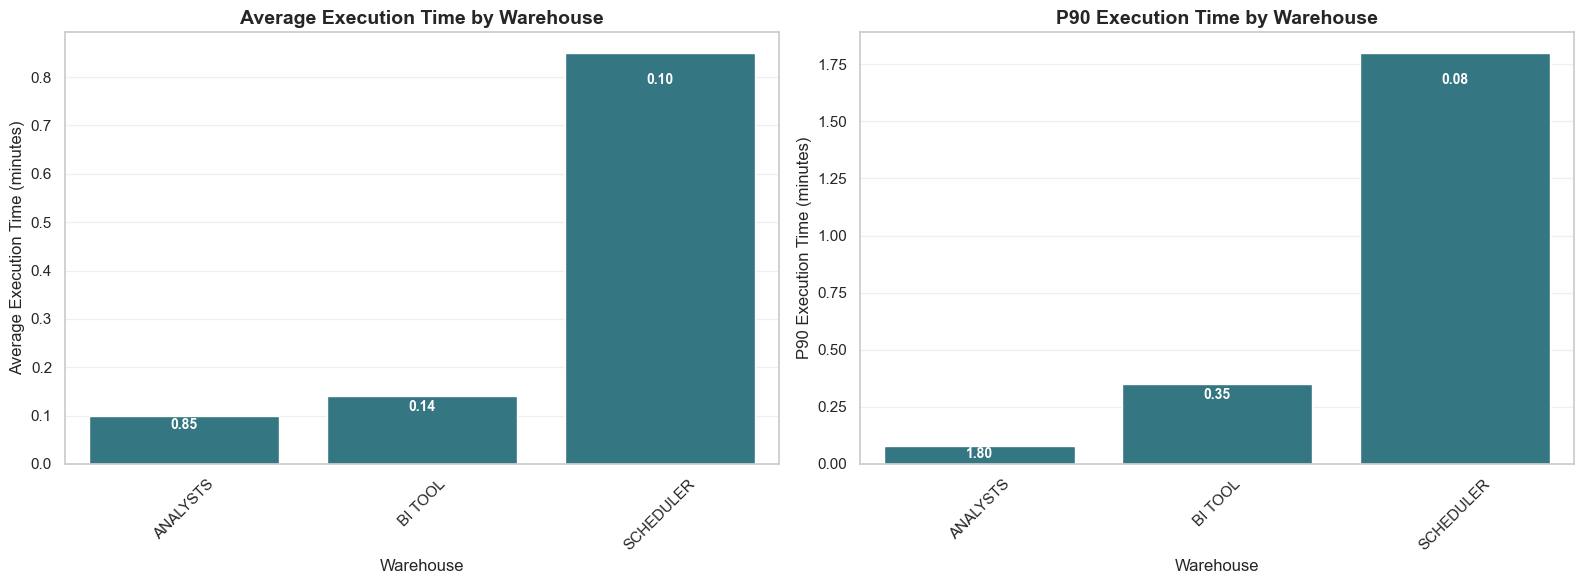

In [4]:
# Calculate average execution time and P90 execution time for each warehouse
print("=" * 70)
print("EXECUTION TIME METRICS BY WAREHOUSE")
print("=" * 70)

warehouse_exec_metrics = query_df.groupby('WAREHOUSE_NAME', observed=True).agg(
    avg_execution_time_min=('EXECUTION_TIME_MIN', 'mean'),
    p90_execution_time_min=('EXECUTION_TIME_MIN', lambda x: x.quantile(0.90)),
    query_count=('QUERY_ID', 'count')
).reset_index()

warehouse_exec_metrics = warehouse_exec_metrics.round(2)
warehouse_exec_metrics = warehouse_exec_metrics.sort_values('avg_execution_time_min', ascending=False)

print("\nExecution Time Metrics by Warehouse:")
display(warehouse_exec_metrics)

# Create two comparison plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Average execution time by warehouse
ax1 = axes[0]
ax1 = sns.barplot(data=warehouse_exec_metrics, x='WAREHOUSE_NAME', y='avg_execution_time_min', 
                  color=ALT_ACCENT, ax=ax1)
ax1.set_xlabel('Warehouse', fontsize=12)
ax1.set_ylabel('Average Execution Time (minutes)', fontsize=12)
ax1.set_title('Average Execution Time by Warehouse', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(ax1.patches, warehouse_exec_metrics['avg_execution_time_min']):
    height = bar.get_height()
    label_y = height * 0.95
    ax1.text(bar.get_x() + bar.get_width()/2., label_y,
             f'{val:.2f}',
             ha='center', va='top', fontsize=10, fontweight='bold', color='white')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Right plot: P90 execution time by warehouse
ax2 = axes[1]
ax2 = sns.barplot(data=warehouse_exec_metrics, x='WAREHOUSE_NAME', y='p90_execution_time_min', 
                  color=ALT_ACCENT, ax=ax2)
ax2.set_xlabel('Warehouse', fontsize=12)
ax2.set_ylabel('P90 Execution Time (minutes)', fontsize=12)
ax2.set_title('P90 Execution Time by Warehouse', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(ax2.patches, warehouse_exec_metrics['p90_execution_time_min']):
    height = bar.get_height()
    label_y = height * 0.95
    ax2.text(bar.get_x() + bar.get_width()/2., label_y,
             f'{val:.2f}',
             ha='center', va='top', fontsize=10, fontweight='bold', color='white')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



In [5]:
# Filter for BI TOOL warehouse during business hours (7 AM - 3 PM, weekdays)
# This subset is used for focused analysis of BI TOOL performance
bi_tool_spilled_query_df = query_df[
    (query_df["WAREHOUSE_NAME"] == "BI TOOL")
    & (query_df["QUERY_HOUR"] >= 7)
    & (query_df["QUERY_HOUR"] <= 15)
    & (query_df["QUERY_WEEKDAY"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]))
    # & (query_df["IS_SPILLED"])  # Uncomment to filter only spilled queries
]

## Spill Analysis

This section analyzes queries that spill data to remote storage. Spilled queries occur when a query's working set exceeds available memory, requiring data to be written to disk/remote storage, which significantly impacts performance.

**Key Metrics Analyzed:**
- Percentage of queries that spill
- Execution time comparison: spilled vs non-spilled queries
- Total execution time breakdown
- Distribution analysis

BI TOOL WAREHOUSE - SPILLED QUERIES ANALYSIS

Total queries in BI TOOL: 1,397,424
Spilled queries: 2,917 (0.2%)
Non-spilled queries: 1,394,507 (99.8%)

EXECUTION TIME ANALYSIS

Total Execution Time:
  Spilled queries: 4,627 min (77.1 hours)
  Non-spilled queries: 169,376 min (2,822.9 hours)
  Total: 174,003 min (2,900.0 hours)
  Spilled % of total execution time: 2.7%

Average Execution Time per Query:
  Spilled queries: 1.59 min
  Non-spilled queries: 0.12 min
  Difference: 1.46 min

Median Execution Time:
  Spilled queries: 0.71 min
  Non-spilled queries: 0.04 min

P90 Execution Time:
  Spilled queries: 4.42 min
  Non-spilled queries: 0.32 min


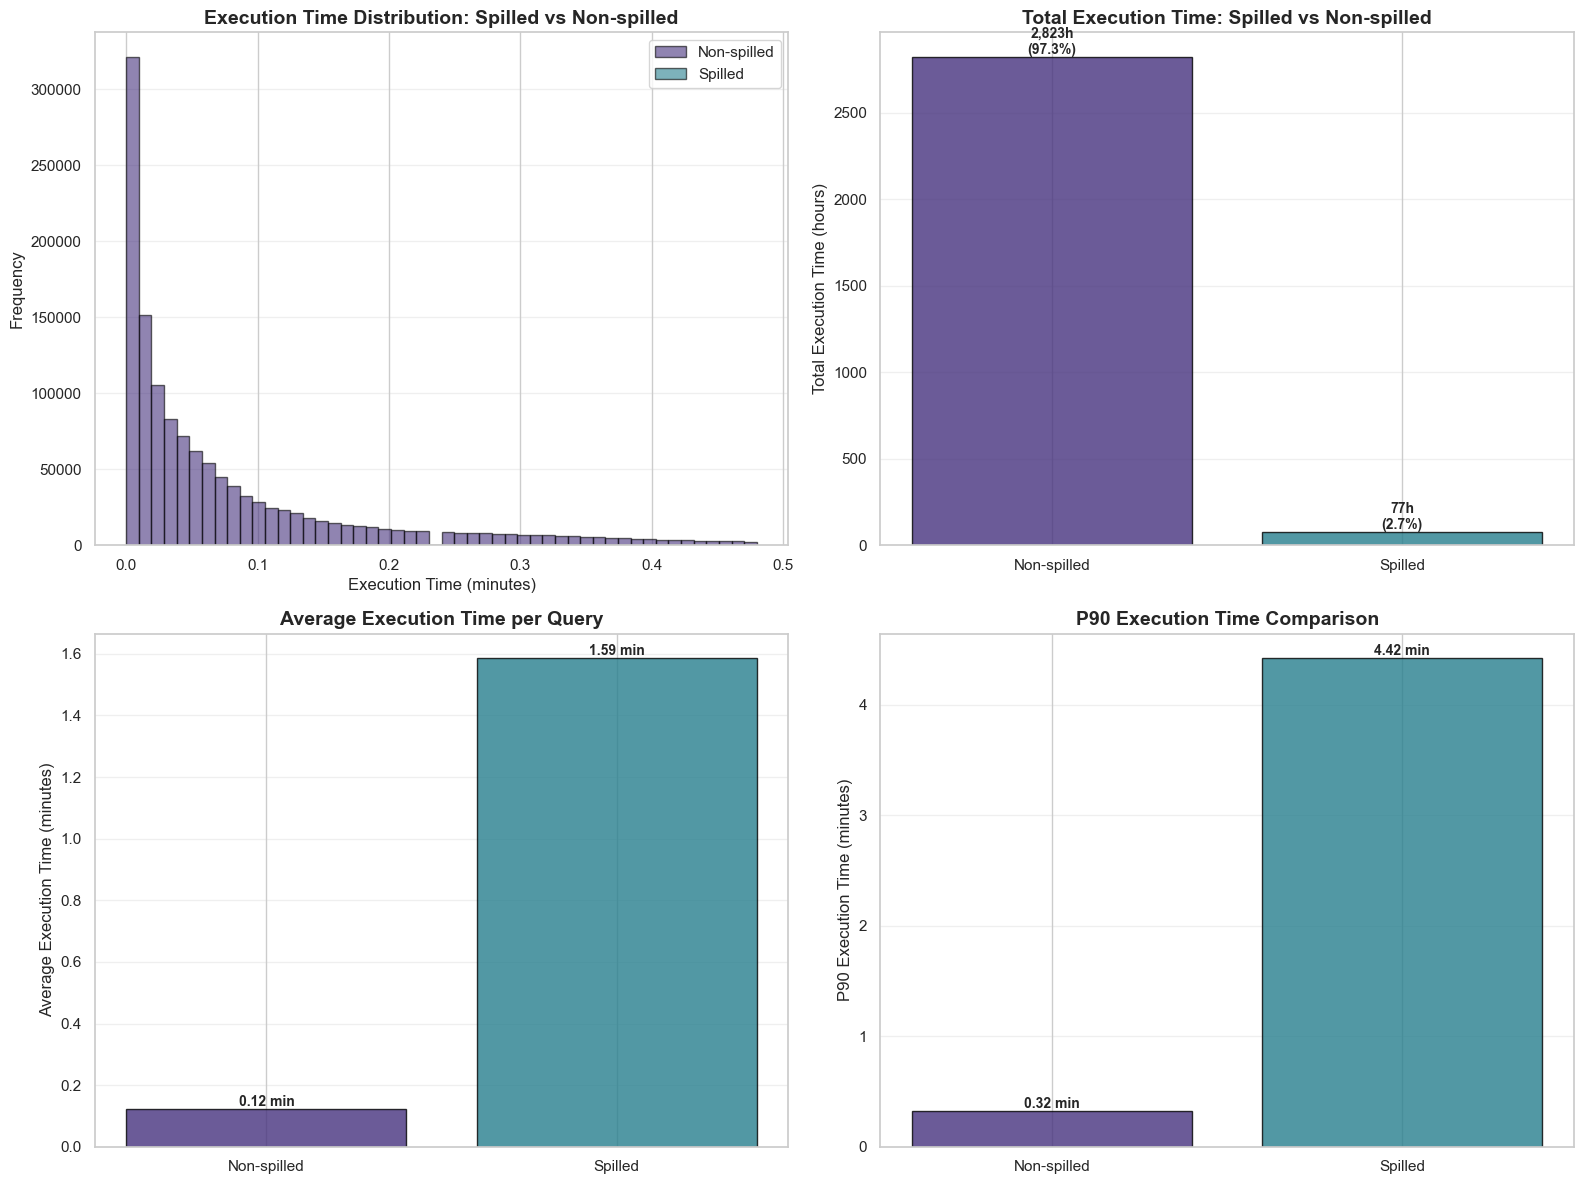


SUMMARY STATISTICS TABLE


,Metric,Non-spilled,Spilled
0,Count,1394507,2917
1,Total Execution Time (hours),"2,822.9",77.1
2,Avg Execution Time (min),0.12,1.59
3,Median Execution Time (min),0.04,0.71
4,P90 Execution Time (min),0.32,4.42


In [6]:
# Filter for BI TOOL warehouse
# bi_tool_df = query_df[query_df['WAREHOUSE_NAME'] == 'BI TOOL'].copy()

bi_tool_df = bi_tool_spilled_query_df
print("=" * 70)
print("BI TOOL WAREHOUSE - SPILLED QUERIES ANALYSIS")
print("=" * 70)

# Basic statistics
total_queries = len(bi_tool_df)
spilled_queries = bi_tool_df[bi_tool_df['IS_SPILLED'] == True]
non_spilled_queries = bi_tool_df[bi_tool_df['IS_SPILLED'] == False]

print(f"\nTotal queries in BI TOOL: {total_queries:,}")
print(f"Spilled queries: {len(spilled_queries):,} ({len(spilled_queries)/total_queries*100:.1f}%)")
print(f"Non-spilled queries: {len(non_spilled_queries):,} ({len(non_spilled_queries)/total_queries*100:.1f}%)")

# Execution time analysis
print("\n" + "=" * 70)
print("EXECUTION TIME ANALYSIS")
print("=" * 70)

spilled_exec_total = spilled_queries['EXECUTION_TIME_MIN'].sum()
non_spilled_exec_total = non_spilled_queries['EXECUTION_TIME_MIN'].sum()
total_exec = spilled_exec_total + non_spilled_exec_total

print(f"\nTotal Execution Time:")
print(f"  Spilled queries: {spilled_exec_total:,.0f} min ({spilled_exec_total/60:,.1f} hours)")
print(f"  Non-spilled queries: {non_spilled_exec_total:,.0f} min ({non_spilled_exec_total/60:,.1f} hours)")
print(f"  Total: {total_exec:,.0f} min ({total_exec/60:,.1f} hours)")
if total_exec > 0:
    print(f"  Spilled % of total execution time: {spilled_exec_total/total_exec*100:.1f}%")

print(f"\nAverage Execution Time per Query:")
print(f"  Spilled queries: {spilled_queries['EXECUTION_TIME_MIN'].mean():.2f} min")
print(f"  Non-spilled queries: {non_spilled_queries['EXECUTION_TIME_MIN'].mean():.2f} min")
print(f"  Difference: {spilled_queries['EXECUTION_TIME_MIN'].mean() - non_spilled_queries['EXECUTION_TIME_MIN'].mean():.2f} min")

print(f"\nMedian Execution Time:")
print(f"  Spilled queries: {spilled_queries['EXECUTION_TIME_MIN'].median():.2f} min")
print(f"  Non-spilled queries: {non_spilled_queries['EXECUTION_TIME_MIN'].median():.2f} min")

print(f"\nP90 Execution Time:")
print(f"  Spilled queries: {spilled_queries['EXECUTION_TIME_MIN'].quantile(0.90):.2f} min")
print(f"  Non-spilled queries: {non_spilled_queries['EXECUTION_TIME_MIN'].quantile(0.90):.2f} min")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top Left: Execution time distribution comparison
ax1 = axes[0, 0]
# Filter outliers for better visualization
max_exec = bi_tool_df['EXECUTION_TIME_MIN'].quantile(0.95)
filtered_spilled = spilled_queries[spilled_queries['EXECUTION_TIME_MIN'] <= max_exec]['EXECUTION_TIME_MIN']
filtered_non_spilled = non_spilled_queries[non_spilled_queries['EXECUTION_TIME_MIN'] <= max_exec]['EXECUTION_TIME_MIN']

ax1.hist(filtered_non_spilled, bins=50, alpha=0.6, label='Non-spilled', color=ALT_ACCENT_2, edgecolor='black')
ax1.hist(filtered_spilled, bins=50, alpha=0.6, label='Spilled', color=ALT_ACCENT, edgecolor='black')
ax1.set_xlabel('Execution Time (minutes)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Execution Time Distribution: Spilled vs Non-spilled', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Top Right: Total execution time breakdown
ax2 = axes[0, 1]
exec_breakdown = pd.DataFrame({
    'Category': ['Non-spilled', 'Spilled'],
    'Execution Time (hours)': [non_spilled_exec_total/60, spilled_exec_total/60]
})

bars = ax2.bar(exec_breakdown['Category'], exec_breakdown['Execution Time (hours)'], 
               color=[ALT_ACCENT_2, ALT_ACCENT], alpha=0.8, edgecolor='black')
ax2.set_ylabel('Total Execution Time (hours)', fontsize=12)
ax2.set_xlabel('')
ax2.set_title('Total Execution Time: Spilled vs Non-spilled', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, exec_breakdown['Execution Time (hours)']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:,.0f}h\n({val/(exec_breakdown["Execution Time (hours)"].sum())*100:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Bottom Left: Average execution time comparison
ax3 = axes[1, 0]
avg_exec = pd.DataFrame({
    'Category': ['Non-spilled', 'Spilled'],
    'Avg Execution Time (min)': [
        non_spilled_queries['EXECUTION_TIME_MIN'].mean(),
        spilled_queries['EXECUTION_TIME_MIN'].mean()
    ]
})

bars = ax3.bar(avg_exec['Category'], avg_exec['Avg Execution Time (min)'],
               color=[ALT_ACCENT_2, ALT_ACCENT], alpha=0.8, edgecolor='black')
ax3.set_ylabel('Average Execution Time (minutes)', fontsize=12)
ax3.set_xlabel('')
ax3.set_title('Average Execution Time per Query', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, avg_exec['Avg Execution Time (min)']):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f} min',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Bottom Right: P90 execution time comparison
ax4 = axes[1, 1]
p90_exec = pd.DataFrame({
    'Category': ['Non-spilled', 'Spilled'],
    'P90 Execution Time (min)': [
        non_spilled_queries['EXECUTION_TIME_MIN'].quantile(0.90),
        spilled_queries['EXECUTION_TIME_MIN'].quantile(0.90)
    ]
})

bars = ax4.bar(p90_exec['Category'], p90_exec['P90 Execution Time (min)'],
               color=[ALT_ACCENT_2, ALT_ACCENT], alpha=0.8, edgecolor='black')
ax4.set_ylabel('P90 Execution Time (minutes)', fontsize=12)
ax4.set_xlabel('')
ax4.set_title('P90 Execution Time Comparison', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, p90_exec['P90 Execution Time (min)']):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2f} min',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "=" * 70)
print("SUMMARY STATISTICS TABLE")
print("=" * 70)
summary_stats = pd.DataFrame({
    'Metric': ['Count', 'Total Execution Time (hours)', 'Avg Execution Time (min)', 
               'Median Execution Time (min)', 'P90 Execution Time (min)'],
    'Non-spilled': [
        len(non_spilled_queries),
        f"{non_spilled_exec_total/60:,.1f}",
        f"{non_spilled_queries['EXECUTION_TIME_MIN'].mean():.2f}",
        f"{non_spilled_queries['EXECUTION_TIME_MIN'].median():.2f}",
        f"{non_spilled_queries['EXECUTION_TIME_MIN'].quantile(0.90):.2f}"
    ],
    'Spilled': [
        len(spilled_queries),
        f"{spilled_exec_total/60:,.1f}",
        f"{spilled_queries['EXECUTION_TIME_MIN'].mean():.2f}",
        f"{spilled_queries['EXECUTION_TIME_MIN'].median():.2f}",
        f"{spilled_queries['EXECUTION_TIME_MIN'].quantile(0.90):.2f}"
    ]
})
display(summary_stats)



## Percentile and Quantile Analysis

This section provides a comprehensive analysis of query performance using percentiles and quantiles:

- **Quartiles (Q1, Q2, Q3, Q4)**: Divide data into 4 equal parts
- **Quintiles**: Divide data into 5 equal parts  
- **Deciles**: Divide data into 10 equal parts
- **Key Percentiles**: P25, P50 (median), P75, P90, P95, P99

These metrics help identify:
- The distribution of query execution times
- Outliers and extreme values
- Performance thresholds for different query categories

QUARTILES (Q1, Q2, Q3, Q4) - Divide data into 4 equal parts
                     Quantile  Total Time (min)
         Q1 (25th percentile)              0.01
Q2 (50th percentile / Median)              0.06
         Q3 (75th percentile)              0.58
  Q4 (100th percentile / Max)            328.23

QUINTILES - Divide data into 5 equal parts
                     Quantile  Total Time (min)
 Quintile 1 (20th percentile)              0.00
 Quintile 2 (40th percentile)              0.02
 Quintile 3 (60th percentile)              0.15
 Quintile 4 (80th percentile)              0.86
Quintile 5 (100th percentile)            328.23

KEY PERCENTILES
Percentile  Total Time (min)
       P25              0.01
       P50              0.06
       P75              0.58
       P90              1.86
       P95              2.99
       P99              7.82

BASIC STATISTICS
Min: 0.00 min
Max: 328.23 min
Mean: 0.68 min
Median (Q2): 0.06 min
Standard Deviation: 2.58 min


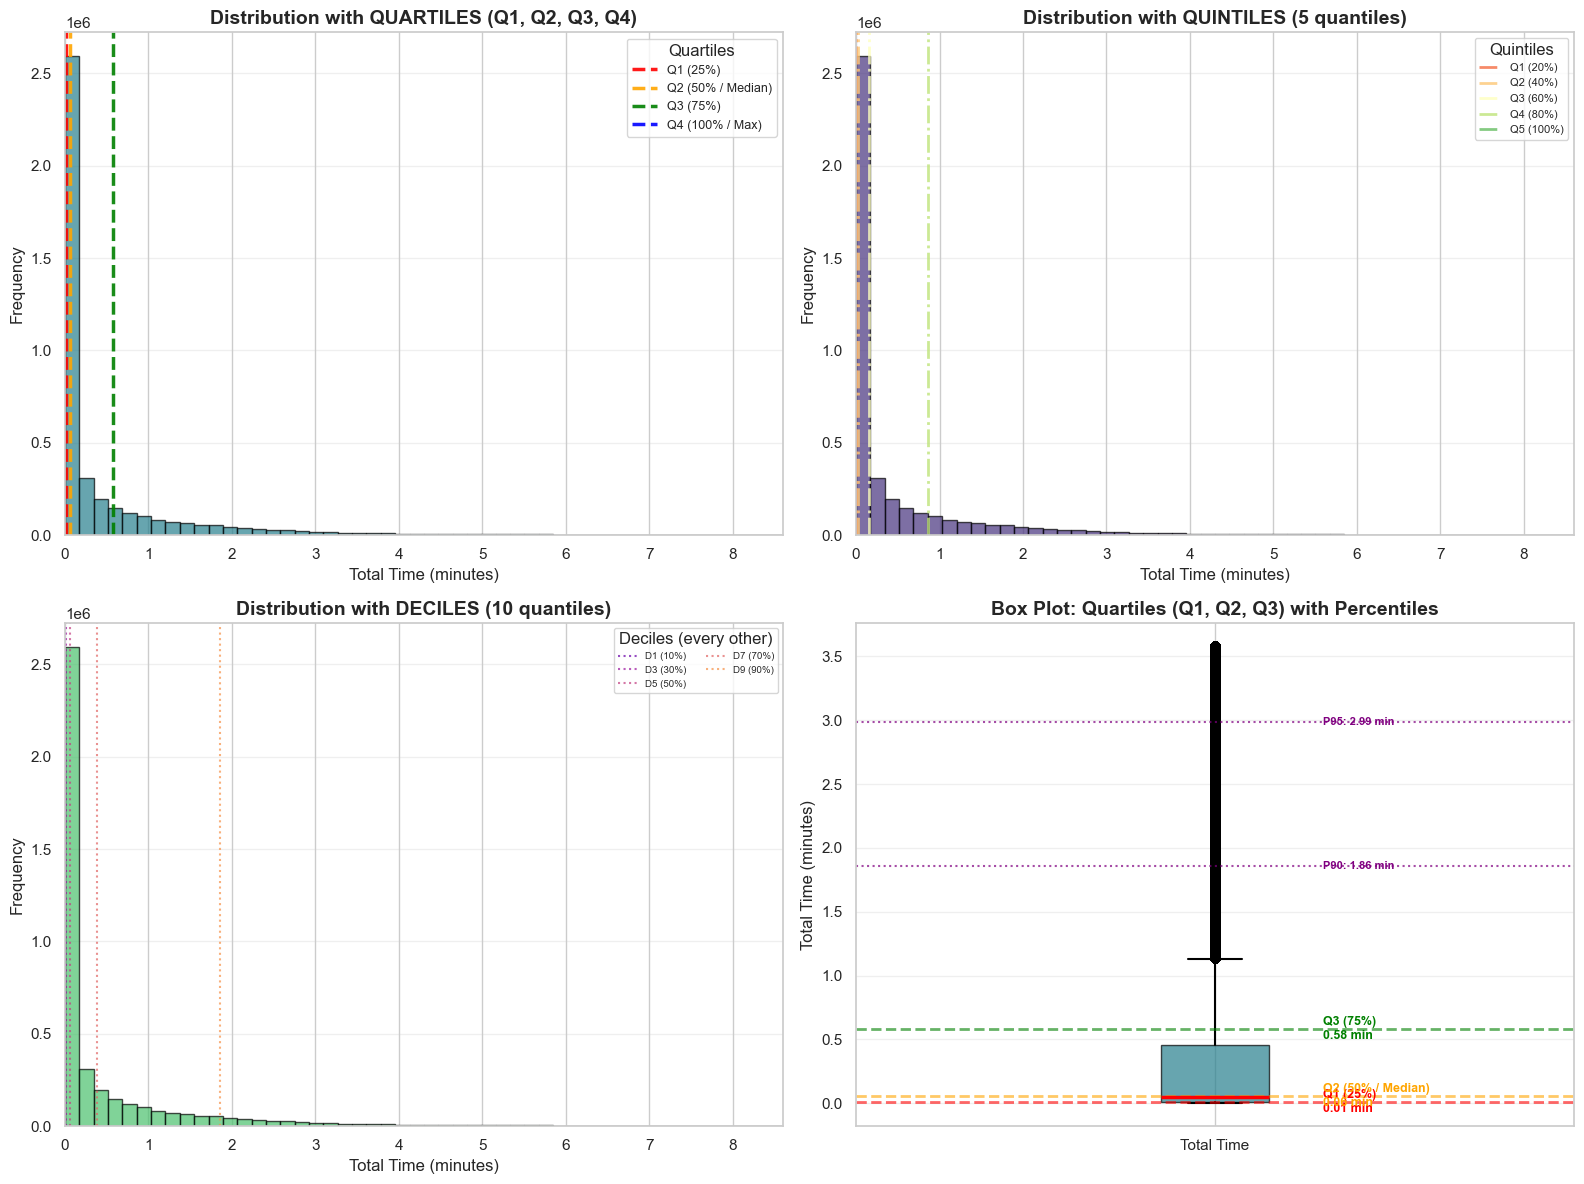

In [7]:
# plot total_time with percentiles and quantiles

# Calculate QUARTILES (Q1, Q2, Q3, Q4) - these are quantiles that divide data into 4 equal parts
quartiles = {
    'Q1 (25th percentile)': query_df['TOTAL_TIME_MIN'].quantile(0.25),
    'Q2 (50th percentile / Median)': query_df['TOTAL_TIME_MIN'].quantile(0.50),
    'Q3 (75th percentile)': query_df['TOTAL_TIME_MIN'].quantile(0.75),
    'Q4 (100th percentile / Max)': query_df['TOTAL_TIME_MIN'].quantile(1.0),
}

# Calculate QUINTILES (5 quantiles) - divide data into 5 equal parts
quintiles = {
    'Quintile 1 (20th percentile)': query_df['TOTAL_TIME_MIN'].quantile(0.20),
    'Quintile 2 (40th percentile)': query_df['TOTAL_TIME_MIN'].quantile(0.40),
    'Quintile 3 (60th percentile)': query_df['TOTAL_TIME_MIN'].quantile(0.60),
    'Quintile 4 (80th percentile)': query_df['TOTAL_TIME_MIN'].quantile(0.80),
    'Quintile 5 (100th percentile)': query_df['TOTAL_TIME_MIN'].quantile(1.0),
}

# Calculate DECILES (10 quantiles) - divide data into 10 equal parts
deciles = {f'Decile {i} ({i*10}th percentile)': query_df['TOTAL_TIME_MIN'].quantile(i/10) 
           for i in range(1, 11)}

# Calculate key percentiles
percentiles = {
    'P25': query_df['TOTAL_TIME_MIN'].quantile(0.25),
    'P50': query_df['TOTAL_TIME_MIN'].quantile(0.50),
    'P75': query_df['TOTAL_TIME_MIN'].quantile(0.75),
    'P90': query_df['TOTAL_TIME_MIN'].quantile(0.90),
    'P95': query_df['TOTAL_TIME_MIN'].quantile(0.95),
    'P99': query_df['TOTAL_TIME_MIN'].quantile(0.99),
}

# Print quartiles summary
print("=" * 60)
print("QUARTILES (Q1, Q2, Q3, Q4) - Divide data into 4 equal parts")
print("=" * 60)
quartile_df = pd.DataFrame([
    {'Quantile': k, 'Total Time (min)': v} 
    for k, v in quartiles.items()
])
print(quartile_df.to_string(index=False))

# Print quintiles summary
print("\n" + "=" * 60)
print("QUINTILES - Divide data into 5 equal parts")
print("=" * 60)
quintile_df = pd.DataFrame([
    {'Quantile': k, 'Total Time (min)': v} 
    for k, v in quintiles.items()
])
print(quintile_df.to_string(index=False))

# Print key percentiles
print("\n" + "=" * 60)
print("KEY PERCENTILES")
print("=" * 60)
percentile_df = pd.DataFrame([
    {'Percentile': k, 'Total Time (min)': v} 
    for k, v in percentiles.items()
])
print(percentile_df.to_string(index=False))

# Print basic statistics
print(f"\n{'=' * 60}")
print("BASIC STATISTICS")
print("=" * 60)
print(f"Min: {query_df['TOTAL_TIME_MIN'].min():.2f} min")
print(f"Max: {query_df['TOTAL_TIME_MIN'].max():.2f} min")
print(f"Mean: {query_df['TOTAL_TIME_MIN'].mean():.2f} min")
print(f"Median (Q2): {query_df['TOTAL_TIME_MIN'].median():.2f} min")
print(f"Standard Deviation: {query_df['TOTAL_TIME_MIN'].std():.2f} min")

# Create visualization with quartiles, quintiles, and percentiles
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top Left: Histogram with QUARTILES
ax1 = axes[0, 0]
max_time = percentiles['P99'] * 1.1
filtered_data = query_df[query_df['TOTAL_TIME_MIN'] <= max_time]['TOTAL_TIME_MIN']

ax1.hist(filtered_data, bins=50, color=ALT_ACCENT, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Total Time (minutes)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution with QUARTILES (Q1, Q2, Q3, Q4)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add quartile lines with distinct colors
quartile_colors = ['red', 'orange', 'green', 'blue']
quartile_labels = ['Q1 (25%)', 'Q2 (50% / Median)', 'Q3 (75%)', 'Q4 (100% / Max)']
for i, ((label, value), color, qlabel) in enumerate(zip(quartiles.items(), quartile_colors, quartile_labels)):
    ax1.axvline(value, color=color, linestyle='--', linewidth=2.5, label=qlabel, alpha=0.9)
ax1.legend(title='Quartiles', loc='upper right', fontsize=9)
ax1.set_xlim(0, max_time)

# Top Right: Histogram with QUINTILES
ax2 = axes[0, 1]
ax2.hist(filtered_data, bins=50, color=ALT_ACCENT_2, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Total Time (minutes)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution with QUINTILES (5 quantiles)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add quintile lines
quintile_colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 5))
for i, ((label, value), color) in enumerate(zip(quintiles.items(), quintile_colors)):
    ax2.axvline(value, color=color, linestyle='-.', linewidth=2, 
                label=f'Q{i+1} ({20*(i+1)}%)', alpha=0.8)
ax2.legend(title='Quintiles', loc='upper right', fontsize=8)
ax2.set_xlim(0, max_time)

# Bottom Left: Histogram with DECILES
ax3 = axes[1, 0]
ax3.hist(filtered_data, bins=50, color=BASE_ACCENT, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Total Time (minutes)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution with DECILES (10 quantiles)', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add decile lines
decile_colors = plt.cm.plasma(np.linspace(0.2, 0.8, 10))
for i, ((label, value), color) in enumerate(zip(deciles.items(), decile_colors)):
    if i % 2 == 0:  # Show every other decile to avoid clutter
        ax3.axvline(value, color=color, linestyle=':', linewidth=1.5, 
                   label=f'D{i+1} ({10*(i+1)}%)', alpha=0.7)
ax3.legend(title='Deciles (every other)', loc='upper right', fontsize=7, ncol=2)
ax3.set_xlim(0, max_time)

# Bottom Right: Box plot showing quartiles with percentile annotations
ax4 = axes[1, 1]
boxplot_data = query_df[query_df['TOTAL_TIME_MIN'] <= percentiles['P95'] * 1.2]['TOTAL_TIME_MIN']
bp = ax4.boxplot([boxplot_data], vert=True, patch_artist=True, 
                 boxprops=dict(facecolor=ALT_ACCENT, alpha=0.7),
                 medianprops=dict(color='red', linewidth=2.5),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

ax4.set_ylabel('Total Time (minutes)', fontsize=12)
ax4.set_title('Box Plot: Quartiles (Q1, Q2, Q3) with Percentiles', fontsize=14, fontweight='bold')
ax4.set_xticklabels(['Total Time'])
ax4.grid(axis='y', alpha=0.3)

# Add quartile annotations (box plot already shows Q1, Q2, Q3, but let's label them)
q1_val = quartiles['Q1 (25th percentile)']
q2_val = quartiles['Q2 (50th percentile / Median)']
q3_val = quartiles['Q3 (75th percentile)']
p90_val = percentiles['P90']
p95_val = percentiles['P95']

# Annotate quartiles
for val, label, color in [(q1_val, 'Q1 (25%)', 'red'), 
                          (q2_val, 'Q2 (50% / Median)', 'orange'),
                          (q3_val, 'Q3 (75%)', 'green')]:
    if val <= boxplot_data.max():
        ax4.axhline(val, color=color, linestyle='--', linewidth=2, alpha=0.6)
        ax4.text(1.15, val, f'{label}\n{val:.2f} min', 
                va='center', fontsize=9, fontweight='bold', color=color)

# Add percentile annotations
for val, label in [(p90_val, 'P90'), (p95_val, 'P95')]:
    if val <= boxplot_data.max():
        ax4.axhline(val, color='purple', linestyle=':', linewidth=1.5, alpha=0.7)
        ax4.text(1.15, val, f'{label}: {val:.2f} min', 
                va='center', fontsize=8, fontweight='bold', color='purple')

plt.tight_layout()
plt.show()


### Percentile Breakdown Visualization

This function creates visualizations showing:
1. **Cumulative queries captured by percentile**: Bar chart showing how many queries fall at or below each percentile threshold
2. **Distribution with percentile lines**: Box plot with key percentile markers overlaid

This helps understand what percentage of queries are captured at different performance thresholds.

,percentile,threshold_min,queries_at_or_below,queries_above,percentile_pct,xtick
0,0.25,0.01,1381550,2829674,25,P25\n(0.01 min)
1,0.50,0.06,2163444,2047780,50,P50\n(0.06 min)
2,0.75,0.58,3163536,1047688,75,P75\n(0.58 min)
3,0.80,0.86,3371417,839807,80,P80\n(0.86 min)
4,0.85,1.27,3582430,628794,85,P85\n(1.27 min)
5,0.90,1.86,3790626,420598,90,P90\n(1.86 min)
6,0.95,2.99,4000710,210514,95,P95\n(2.99 min)
7,0.99,7.82,4169185,42039,99,P99\n(7.82 min)


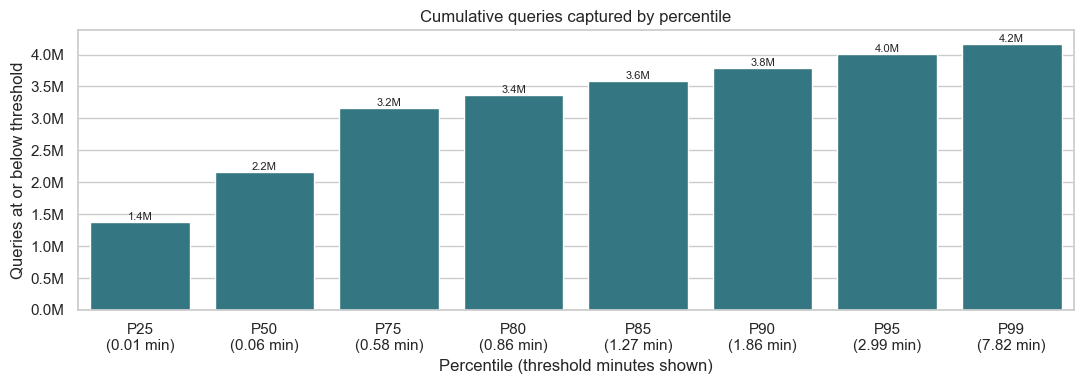

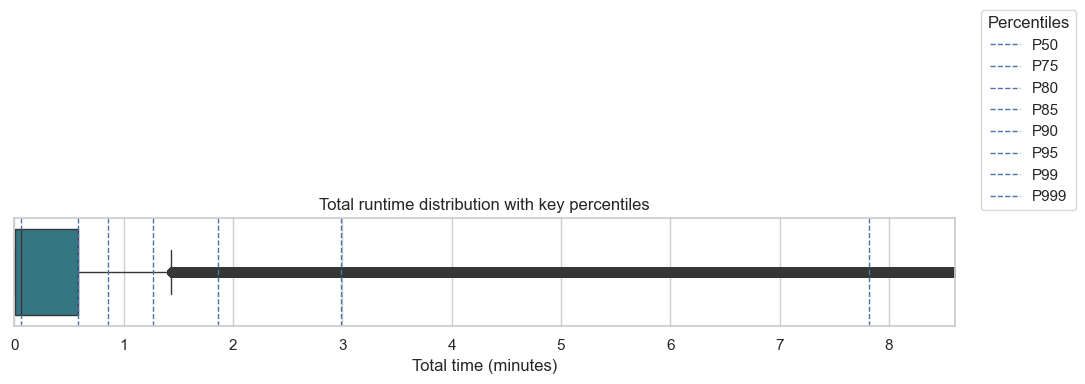

In [8]:
# Note: plot_percentile_breakdown is now imported from visualization.py
plot_percentile_breakdown(query_df, 'TOTAL_TIME_MIN')
# plot_percentile_breakdown(query_df, 'EXECUTION_TIME_MIN')

## Execution vs Queueing Time Analysis

This section analyzes the breakdown between execution time and queueing time for slow queries.

**Key Insights:**
- **Execution Time**: Time spent actually running the query
- **Queueing Time**: Time spent waiting in queue before execution starts
- **Total Time**: Sum of execution and queueing time

The analysis uses each category's P90 threshold to identify slow queries, allowing for category-specific performance benchmarks.

TIME BREAKDOWN BY WAREHOUSE_SIZE (Using Each Category's P90 Threshold)

P90 Thresholds by WAREHOUSE_SIZE:
WAREHOUSE_SIZE  p90_total_min
       X-Small           2.79
         Small           1.84
        Medium           0.70

X-Small (P90 threshold: 2.79 min):
  Slow queries count: 170,984
  Total Execution Time: 711,775 min (11,862.9 hours)
  Total Queueing Time: 482,857 min (8,047.6 hours)
  Total Time: 1,194,632 min (19,910.5 hours)
  Execution %: 59.6%
  Queueing %: 40.4%

Small (P90 threshold: 1.84 min):
  Slow queries count: 167,535
  Total Execution Time: 118,585 min (1,976.4 hours)
  Total Queueing Time: 400,868 min (6,681.1 hours)
  Total Time: 519,453 min (8,657.6 hours)
  Execution %: 22.8%
  Queueing %: 77.2%

Medium (P90 threshold: 0.70 min):
  Slow queries count: 89
  Total Execution Time: 22 min (0.4 hours)
  Total Queueing Time: 69 min (1.2 hours)
  Total Time: 91 min (1.5 hours)
  Execution %: 23.7%
  Queueing %: 76.3%


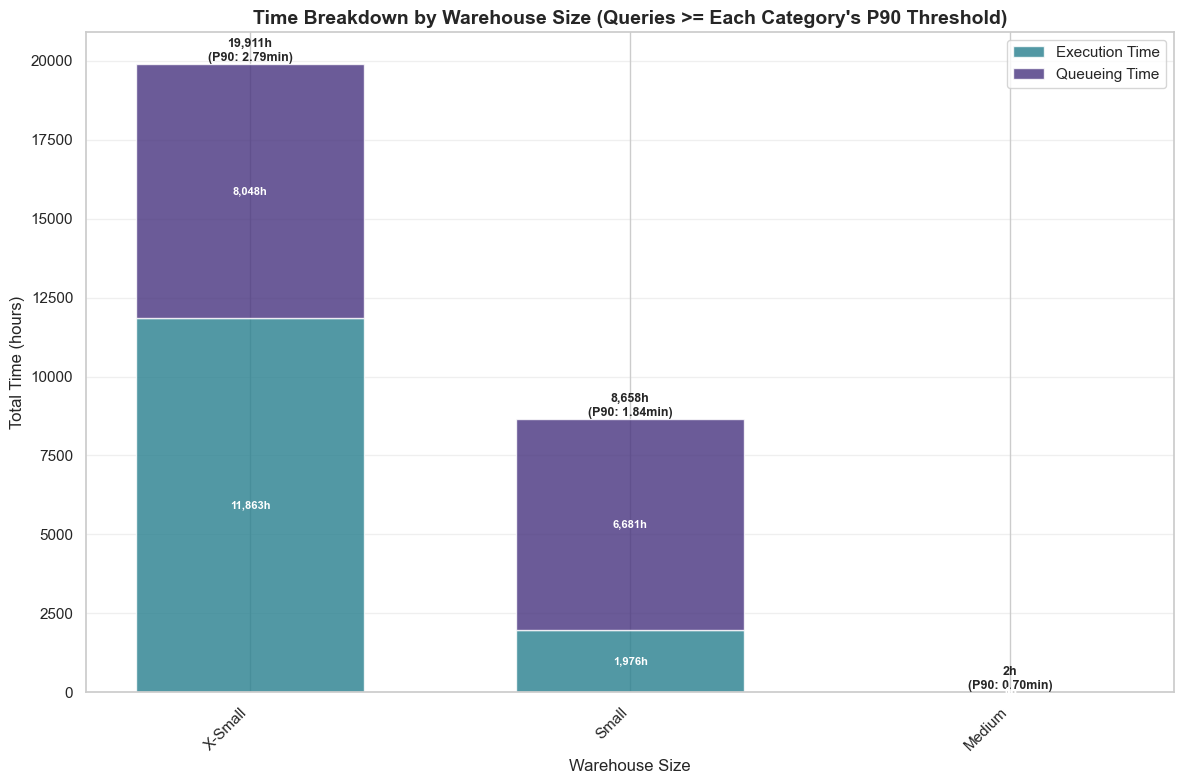


SUMMARY TABLE: Time Breakdown by Warehouse Size (P90+ Queries)


,Category,Execution Time (hours),Queueing Time (hours),P90 Threshold (min)
0,X-Small,11862.923167,8047.610333,2.79
1,Small,1976.416333,6681.137333,1.84
2,Medium,0.359167,1.156667,0.70


,Category,Execution Time (hours),Queueing Time (hours),P90 Threshold (min)
0,X-Small,11862.923167,8047.610333,2.79
1,Small,1976.416333,6681.137333,1.84
2,Medium,0.359167,1.156667,0.70


In [9]:
# Note: visualize_time_breakdown_by_category is now imported from visualization.py
# Example usage - can use different grouping columns
# visualize_time_breakdown_by_category(query_df, 'HUMAN_USER')
# visualize_time_breakdown_by_category(query_df, 'WAREHOUSE_NAME')
visualize_time_breakdown_by_category(query_df, 'WAREHOUSE_SIZE')
# visualize_time_breakdown_by_category(query_df, 'QUERY_TYPE')


## Stacked Bar Plot: Execution vs Queueing Time

This section visualizes execution time and queueing time as stacked bar plots, allowing comparison of time components across different categories.

### Metric Options: Total Time vs Average Time

This function supports two metric types for the y-axis:
- **Total Time**: Sum of all execution/queueing time for slow queries (useful for understanding overall impact)
- **Average Time**: Mean execution/queueing time per query (useful for understanding typical query performance)

TOTAL TIME BREAKDOWN BY IS_SPILLED (Using Each Category's P90 Threshold)

P90 Thresholds by IS_SPILLED:
 IS_SPILLED  p90_total_min
       True          18.62
      False           1.75

True (P90 threshold: 18.62 min):
  Slow queries count: 4,625
  Total Execution Time: 179,748 min (2,995.8 hours)
  Total Queueing Time: 9,541 min (159.0 hours)
  Total Time: 189,289 min (3,154.8 hours)
  Execution %: 95.0%
  Queueing %: 5.0%

False (P90 threshold: 1.75 min):
  Slow queries count: 417,484
  Total Execution Time: 593,924 min (9,898.7 hours)
  Total Queueing Time: 971,767 min (16,196.1 hours)
  Total Time: 1,565,692 min (26,094.9 hours)
  Execution %: 37.9%
  Queueing %: 62.1%


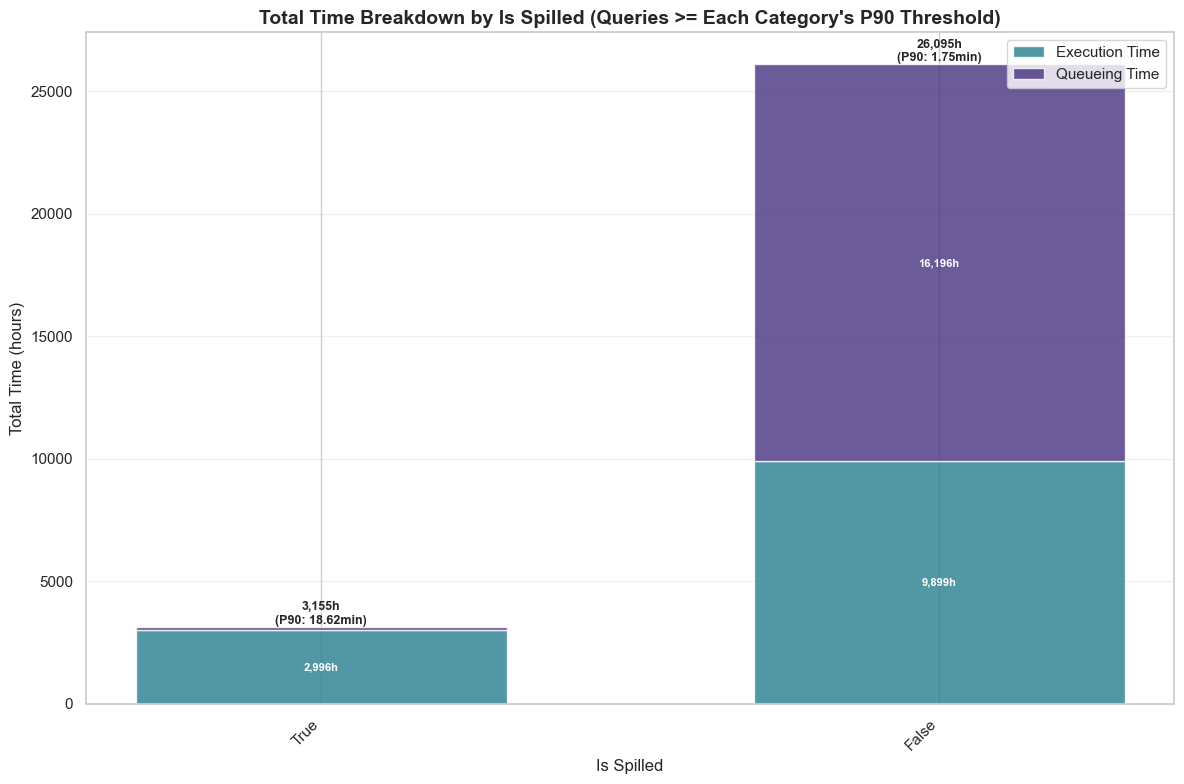


SUMMARY TABLE: Total Time Breakdown by Is Spilled (P90+ Queries)


,Category,Execution Time (hours),Queueing Time (hours),P90 Threshold (min)
0,True,2995.7980,159.021500,18.62
1,False,9898.7385,16196.122167,1.75


AVERAGE TIME BREAKDOWN BY IS_SPILLED (Using Each Category's P90 Threshold)

P90 Thresholds by IS_SPILLED:
 IS_SPILLED  p90_total_min
       True          18.62
      False           1.75

True (P90 threshold: 18.62 min):
  Slow queries count: 4,625
  Average Execution Time: 38.86 min (0.648 hours)
  Average Queueing Time: 2.06 min (0.034 hours)
  Average Total Time: 41.32 min (0.689 hours)
  Execution %: 94.0%
  Queueing %: 5.0%

False (P90 threshold: 1.75 min):
  Slow queries count: 417,484
  Average Execution Time: 1.42 min (0.024 hours)
  Average Queueing Time: 2.33 min (0.039 hours)
  Average Total Time: 3.77 min (0.063 hours)
  Execution %: 37.7%
  Queueing %: 61.7%


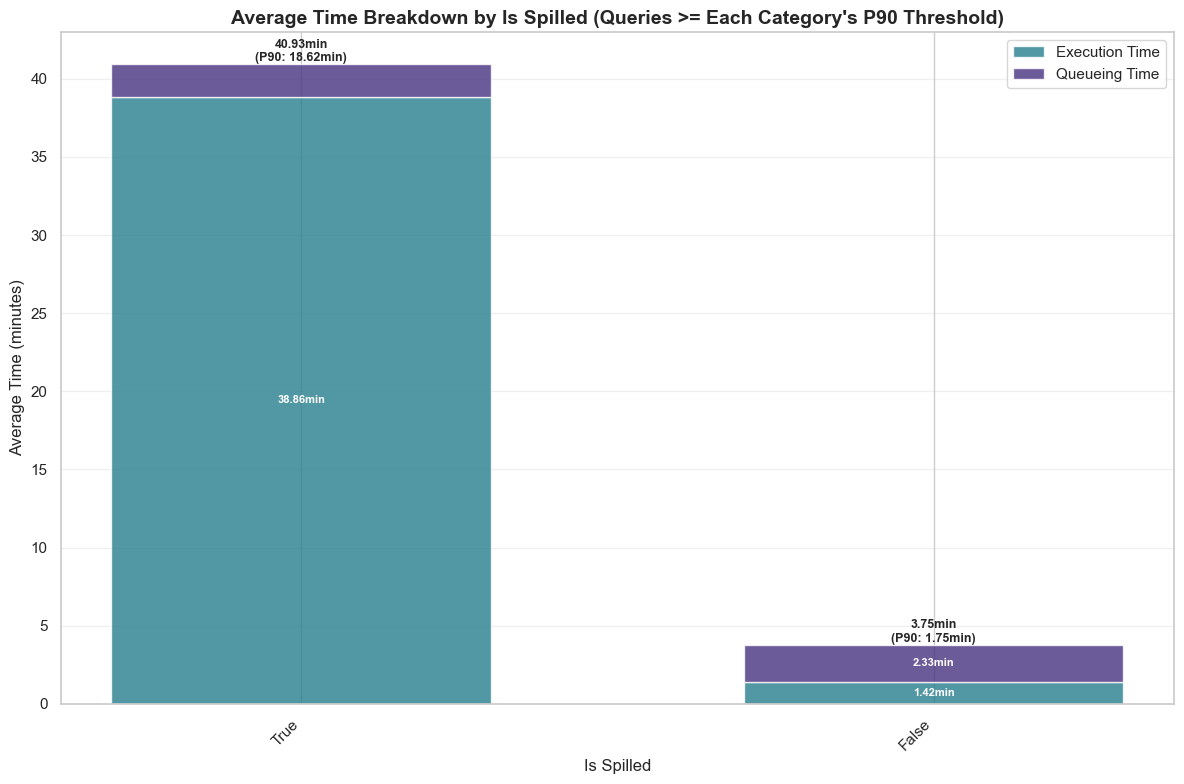


SUMMARY TABLE: Average Time Breakdown by Is Spilled (P90+ Queries)


,Category,Execution Time (minutes),Queueing Time (minutes),P90 Threshold (min)
0,True,38.864406,2.062982,18.62
1,False,1.422628,2.327676,1.75


,Category,Execution Time,Queueing Time,P90 Threshold (min)
0,True,38.864406,2.062982,18.62
1,False,1.422628,2.327676,1.75


In [10]:
# Note: visualize_time_breakdown_by_category_v2 is now imported from visualization.py
# Example usage:
# visualize_time_breakdown_by_category_v2(query_df, 'WAREHOUSE_NAME', metric='total')
# visualize_time_breakdown_by_category_v2(query_df, 'WAREHOUSE_NAME', metric='average')
visualize_time_breakdown_by_category_v2(query_df, 'IS_SPILLED', metric='total')
visualize_time_breakdown_by_category_v2(query_df, 'IS_SPILLED', metric='average')


Execution and Queueing Time by Percentile:


,percentile_pct,threshold_min,query_count,total_execution_hr,total_queueing_hr,total_time_hr
0,25,0.01,1381550,40.472833,0.389500,40.862333
1,50,0.06,2163444,348.997167,21.959667,370.956833
2,75,0.58,3163536,2721.874833,1553.968500,4275.843333
3,80,0.86,3371417,3722.593167,2990.616000,6713.209167
4,85,1.27,3582430,4959.637167,5424.137500,10383.774667
5,90,1.86,3790626,6587.564333,9123.628500,15711.192833
6,95,2.99,4000710,8996.818833,14852.327333,23849.146167
7,99,7.82,4169185,13713.956833,22700.177667,36414.134500


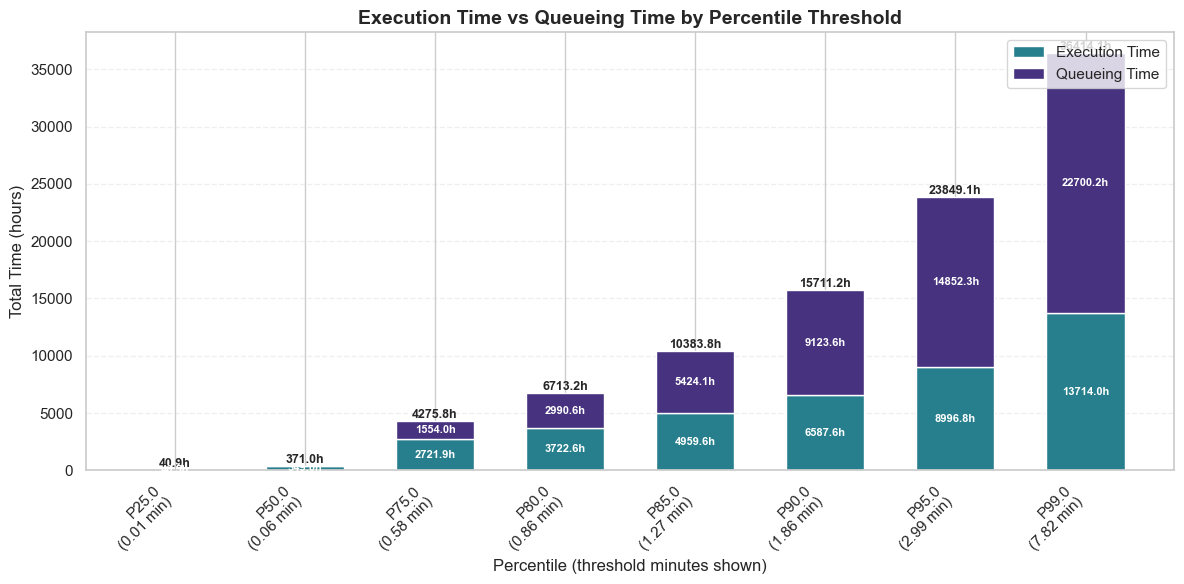

In [11]:
# Note: plot_execution_queueing_by_percentile is now imported from visualization.py
# Plot execution and queueing time by percentile
plot_execution_queueing_by_percentile(query_df, time_col='TOTAL_TIME_MIN')


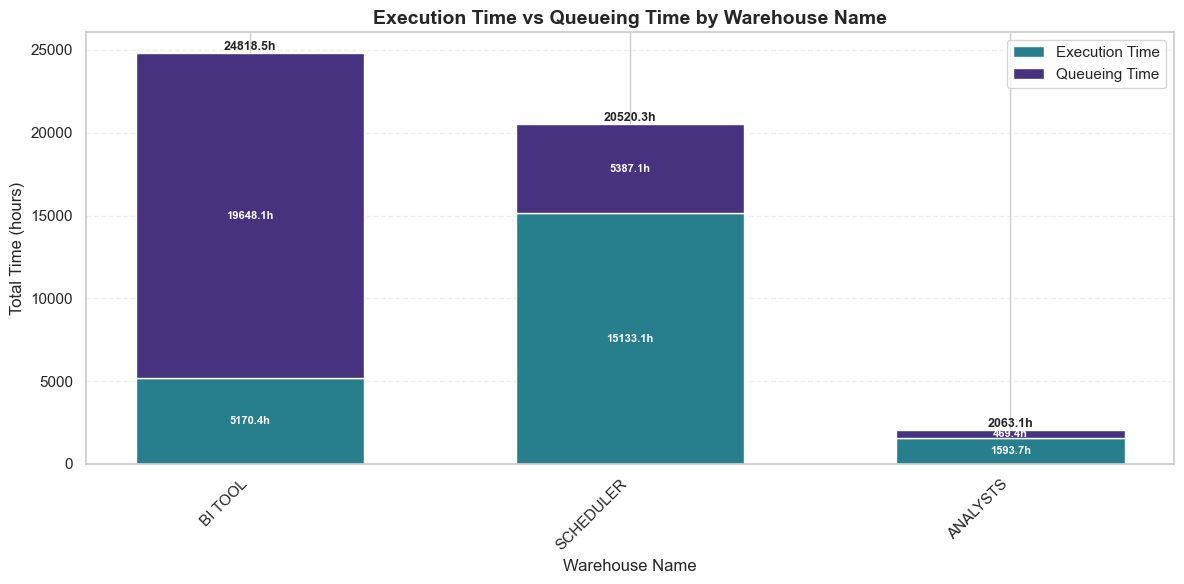


Summary by Warehouse Name:
WAREHOUSE_NAME  query_count  total_execution_hr  total_queueing_hr  total_time_hr
       BI TOOL      2197888         5170.402667       19648.121167   24818.523833
     SCHEDULER      1064854        15133.145167        5387.123500   20520.268667
      ANALYSTS       948482         1593.711333         469.407667    2063.119000


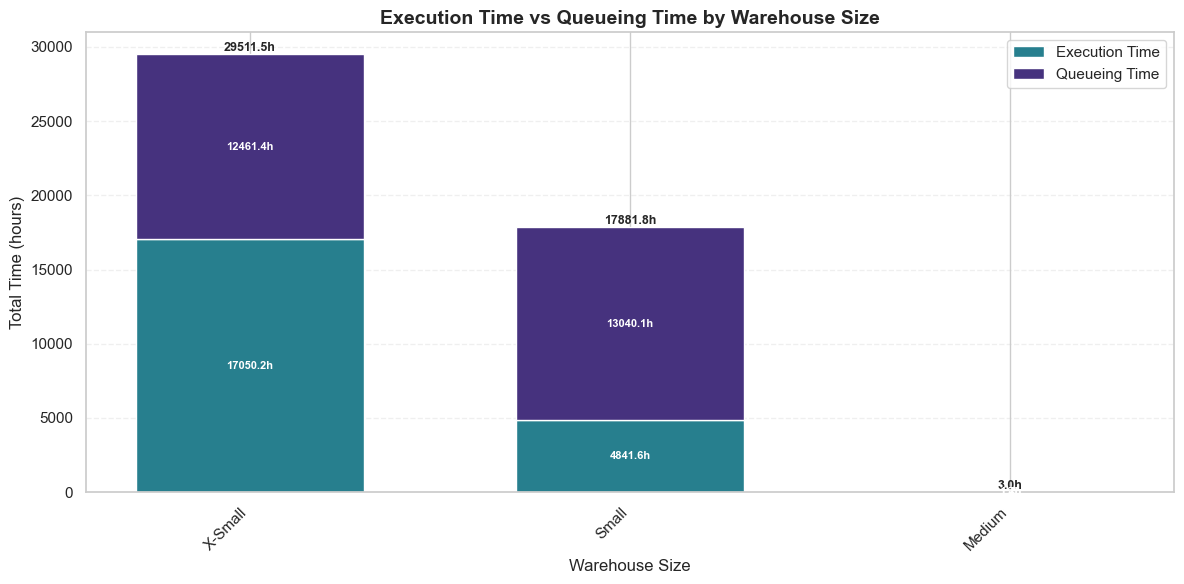


Summary by Warehouse Size:
WAREHOUSE_SIZE  query_count  total_execution_hr  total_queueing_hr  total_time_hr
       X-Small      1705146          17050.1580       12461.382500   29511.540500
         Small      1663460           4841.6400       13040.142833   17881.782833
        Medium          860              1.3565           1.650167       3.006667


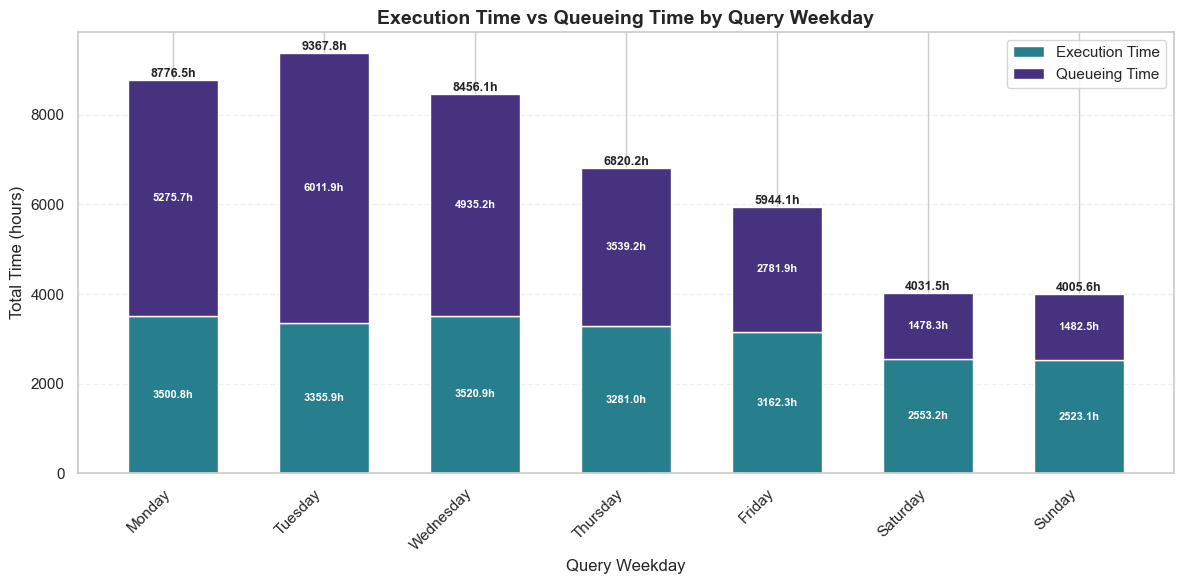


Summary by Query Weekday:
QUERY_WEEKDAY  query_count  total_execution_hr  total_queueing_hr  total_time_hr
       Monday       757657         3500.813500        5275.734000    8776.547500
      Tuesday       770943         3355.854500        6011.939667    9367.794167
    Wednesday       760709         3520.907667        4935.210167    8456.117833
     Thursday       712930         3281.027000        3539.209500    6820.236500
       Friday       638112         3162.290000        2781.858000    5944.148000
     Saturday       279725         2553.220667        1478.250833    4031.471500
       Sunday       291148         2523.145833        1482.450167    4005.596000


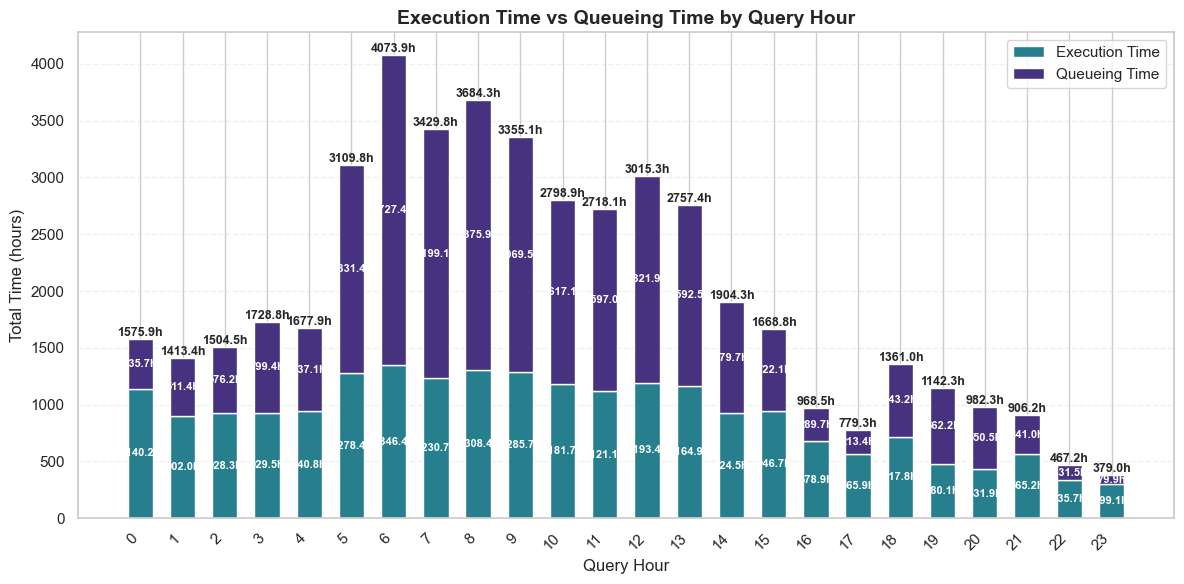


Summary by Query Hour:
 QUERY_HOUR  query_count  total_execution_hr  total_queueing_hr  total_time_hr
          0       102193         1140.225500         435.658833    1575.884333
          1       103346          902.008667         511.368000    1413.376667
          2       271741          928.292667         576.158667    1504.451333
          3        79178          929.462000         799.383667    1728.845667
          4        91668          940.809167         737.074333    1677.883500
          5       114402         1278.353167        1831.421333    3109.774500
          6       258476         1346.412333        2727.444667    4073.857000
          7       264788         1230.668667        2199.137000    3429.805667
          8       283765         1308.393167        2375.918000    3684.311167
          9       266556         1285.652000        2069.474000    3355.126000
         10       265945         1181.746000        1617.114500    2798.860500
         11       267317    

In [12]:
# Note: visualise_execution_and_queueing_time is now imported from visualization.py
visualise_execution_and_queueing_time(query_df, 'WAREHOUSE_NAME')
visualise_execution_and_queueing_time(query_df, 'WAREHOUSE_SIZE')
visualise_execution_and_queueing_time(query_df, 'QUERY_WEEKDAY')
visualise_execution_and_queueing_time(query_df, 'QUERY_HOUR')


,QUERY_ID,TOTAL_TIME,EXECUTION_TIME,QUEUEING_TIME,BYTES_SPILLED_TO_REMOTE,TOTAL_TIME_MS,EXECUTION_TIME_MS,QUEUEING_TIME_MS,TOTAL_TIME_MIN,EXECUTION_TIME_MIN,QUEUEING_TIME_MIN,EXECUTION_AND_QUEUEING_TIME_MIN,TIME_DELAY_MIN,IS_SPILLED,QUERY_START_TIME,DATABASE_ID,WAREHOUSE_NAME,QUERY_TYPE,WAREHOUSE_SIZE,HUMAN_USER,SCHEMA_INDEX,SCHEMA_NAME,SCHEMA_TOUCHES,SCHEMA_TOUCHES_BIN,QUERY_DATE,QUERY_HOUR,QUERY_WEEKDAY
0,0000019b03c47f7ede7049e82222a228f96e4b1bd55937...,59436,1591,57655,0,59436,1591,57655,0.99,0.03,0.96,0.99,0.00,False,2021-06-03 08:26:12.725,6.0,BI TOOL,SELECT,Small,Automated,0,REPORTS,1,2-3,2021-06-03,8,Thursday
1,000004f59f21775c56e7008b3bf82364674efd0a0f79c2...,38484,1869,35681,0,38484,1869,35681,0.64,0.03,0.59,0.62,-0.02,False,2021-05-26 06:50:25.986,6.0,BI TOOL,SELECT,Small,Automated,0,REPORTS,1,2-3,2021-05-26,6,Wednesday
2,00000693f48e84d33f9b231368c1c88b999818e4a15370...,1338,837,0,0,1338,837,0,0.02,0.01,0.00,0.01,-0.01,False,2021-04-18 14:07:07.007,6.0,SCHEDULER,CREATE_TABLE_AS_SELECT,X-Small,Automated,0,REPORTS,1,2-3,2021-04-18,14,Sunday
3,0000085f4e3115cfee4281a520816372ea742ae007a581...,60702,60437,0,0,60702,60437,0,1.01,1.01,0.00,1.01,0.00,False,2021-05-14 13:20:11.343,6.0,SCHEDULER,CREATE_TABLE_AS_SELECT,X-Small,Automated,0,TRANSFER,1,2-3,2021-05-14,13,Friday
4,00000a044796d1b66ab2d59bf917e6cfdc50b06eb944a6...,74931,4319,70400,0,74931,4319,70400,1.25,0.07,1.17,1.24,-0.01,False,2021-04-28 06:41:47.919,6.0,BI TOOL,SELECT,Small,Automated,0,REPORTS,1,2-3,2021-04-28,6,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4211219,ffffedda16f6077d1f2405ac5fb07f7f5475d8613d86dc...,28513,1900,26237,0,28513,1900,26237,0.48,0.03,0.44,0.47,-0.01,False,2021-04-12 10:50:30.641,6.0,BI TOOL,SELECT,Small,Automated,0,REPORTS,1,2-3,2021-04-12,10,Monday
4211220,ffffee58da1815f623960a126a99b3422134012383b41c...,90210,3352,86461,0,90210,3352,86461,1.50,0.06,1.44,1.50,0.00,False,2021-04-19 07:13:18.028,6.0,BI TOOL,SELECT,Small,Automated,0,DDCASE,1,2-3,2021-04-19,7,Monday
4211221,fffff0029a6ac86cff0e21feeac6ac27a845331a67ca1a...,871,687,0,0,871,687,0,0.01,0.01,0.00,0.01,0.00,False,2021-06-10 10:54:38.998,6.0,BI TOOL,SELECT,Small,Automated,0,REPORTS,1,2-3,2021-06-10,10,Thursday
4211222,fffff1f9d9bcfd39de4a6e2eb9f356e096f9fbf2f59a85...,1635,1434,0,0,1635,1434,0,0.03,0.02,0.00,0.02,-0.01,False,2021-05-04 10:23:36.662,6.0,BI TOOL,SELECT,Small,Automated,0,REPORTS,1,2-3,2021-05-04,10,Tuesday


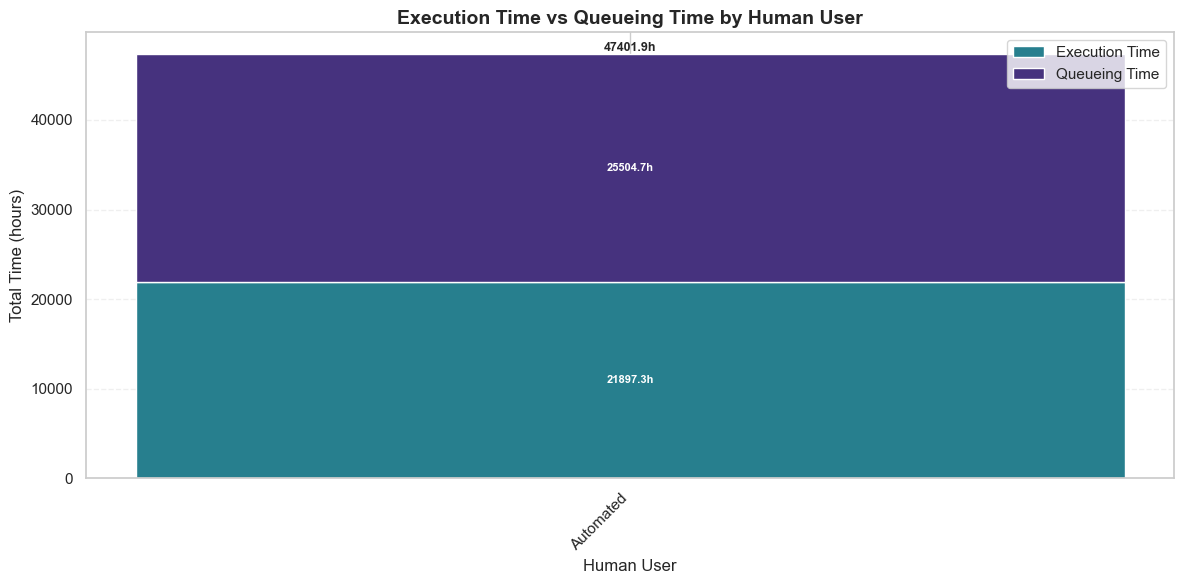


Summary by Human User:
HUMAN_USER  query_count  total_execution_hr  total_queueing_hr  total_time_hr
 Automated      4211224        21897.259167       25504.652333     47401.9115


In [13]:
display(query_df)
visualise_execution_and_queueing_time(query_df, 'HUMAN_USER')

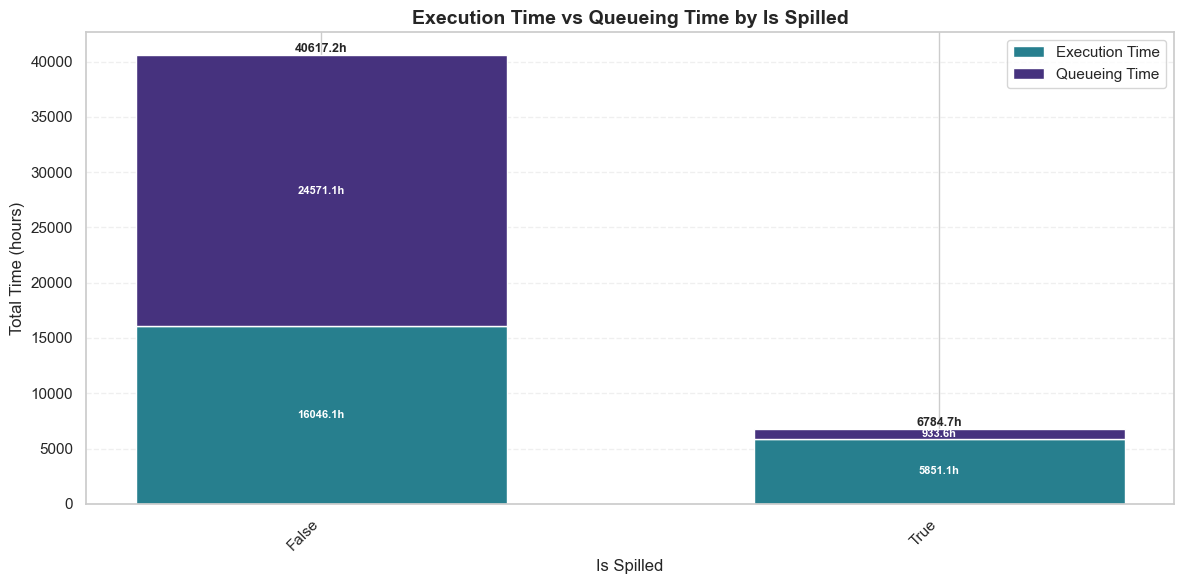


Summary by Is Spilled:
 IS_SPILLED  query_count  total_execution_hr  total_queueing_hr  total_time_hr
      False      4165027        16046.116167       24571.101167   40617.217333
       True        46197         5851.143000         933.551167    6784.694167


In [14]:
visualise_execution_and_queueing_time(query_df, 'IS_SPILLED')

TIME BREAKDOWN BY QUERY_TYPE

P90 Thresholds by QUERY_TYPE:
            QUERY_TYPE  p90_total_min
                 MERGE           5.09
CREATE_TABLE_AS_SELECT           4.35
                UPDATE           3.32
                SELECT           1.82
                INSERT           1.68
                UNLOAD           1.35
                DELETE           0.41
          CREATE_TABLE           0.02
             RECLUSTER           0.01
                   SET           0.01
           CREATE_VIEW           0.00
               UNKNOWN           0.00

MERGE (P90 threshold: 5.09 min):
  Slow queries count: 3,986
  Total Time: 57,136 min (952.3 hours)

CREATE_TABLE_AS_SELECT (P90 threshold: 4.35 min):
  Slow queries count: 39,352
  Total Time: 507,075 min (8,451.3 hours)

UPDATE (P90 threshold: 3.32 min):
  Slow queries count: 6,216
  Total Time: 38,539 min (642.3 hours)

SELECT (P90 threshold: 1.82 min):
  Slow queries count: 292,934
  Total Time: 994,391 min (16,573.2 hours)

INSERT (P90 

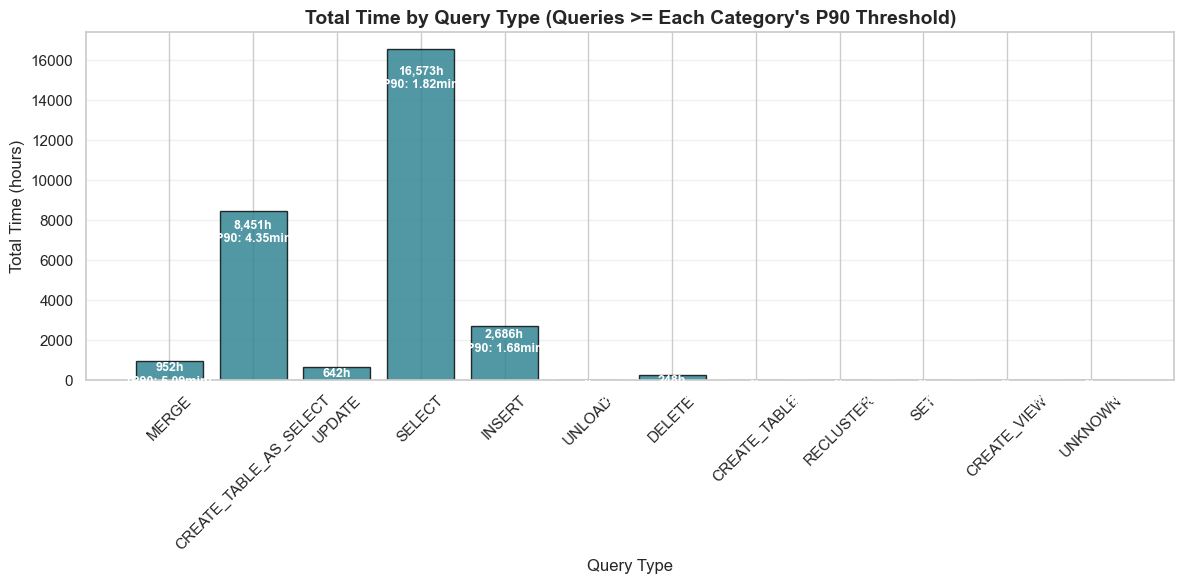


SUMMARY TABLE: Time Breakdown by Query Type (P90+ Queries)


,Category,Total Time (hours),P90 Threshold (min)
0,MERGE,952.270333,5.09
1,CREATE_TABLE_AS_SELECT,8451.253667,4.35
2,UPDATE,642.324333,3.32
3,SELECT,16573.177667,1.82
4,INSERT,2685.751333,1.68
5,UNLOAD,1.328000,1.35
6,DELETE,247.894167,0.41
7,CREATE_TABLE,0.010167,0.02
8,RECLUSTER,0.000333,0.01
9,SET,0.369833,0.01


,Category,Total Time (hours),P90 Threshold (min)
0,MERGE,952.270333,5.09
1,CREATE_TABLE_AS_SELECT,8451.253667,4.35
2,UPDATE,642.324333,3.32
3,SELECT,16573.177667,1.82
4,INSERT,2685.751333,1.68
5,UNLOAD,1.328000,1.35
6,DELETE,247.894167,0.41
7,CREATE_TABLE,0.010167,0.02
8,RECLUSTER,0.000333,0.01
9,SET,0.369833,0.01


In [15]:
# Note: analyze_time_breakdown_by_category_v2 is now imported from visualization.py
# Replace the old function with this one, or use this directly:
# analyze_time_breakdown_by_category_v2(query_df, 'WAREHOUSE_NAME')
# analyze_time_breakdown_by_category_v2(query_df, 'WAREHOUSE_SIZE')
analyze_time_breakdown_by_category_v2(query_df, 'QUERY_TYPE')


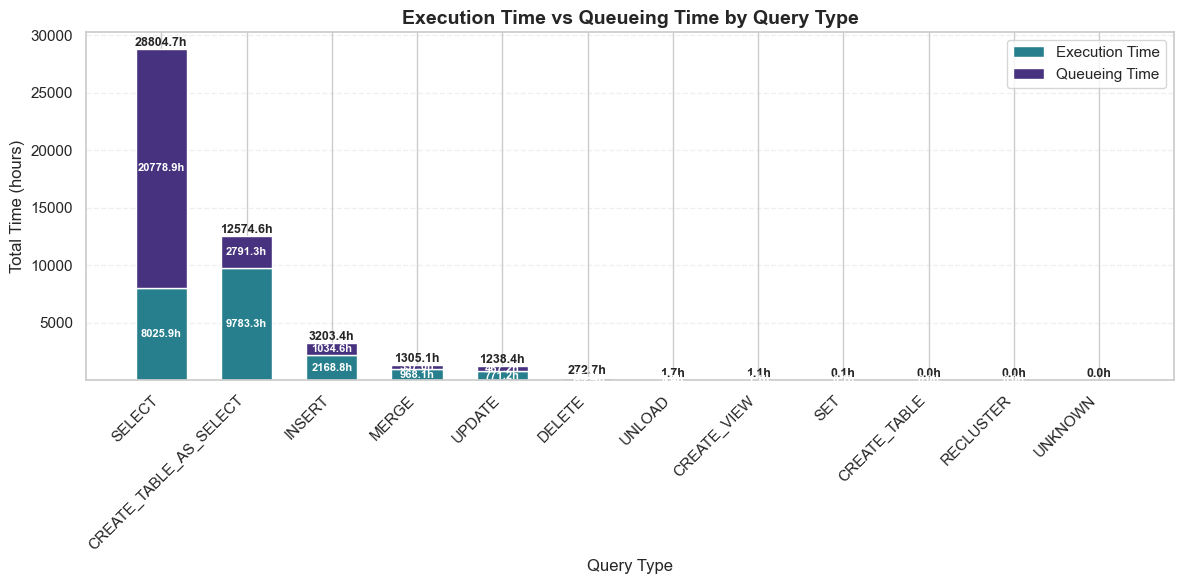


Summary by Query Type:
            QUERY_TYPE  query_count  total_execution_hr  total_queueing_hr  total_time_hr
                SELECT      2911304         8025.874500       20778.867667   28804.742167
CREATE_TABLE_AS_SELECT       393422         9783.308333        2791.331333   12574.639667
                INSERT       298735         2168.803333        1034.571667    3203.375000
                 MERGE        39853          968.091500         337.046833    1305.138333
                UPDATE        62073          771.219167         467.157000    1238.376167
                DELETE        70530          177.397667          95.335000     272.732667
                UNLOAD          251            1.378833           0.335500       1.714333
           CREATE_VIEW       420540            1.089333           0.000000       1.089333
                   SET         7506            0.091500           0.007333       0.098833
          CREATE_TABLE          136            0.004833           0.000000  

In [16]:
visualise_execution_and_queueing_time(query_df, 'QUERY_TYPE')

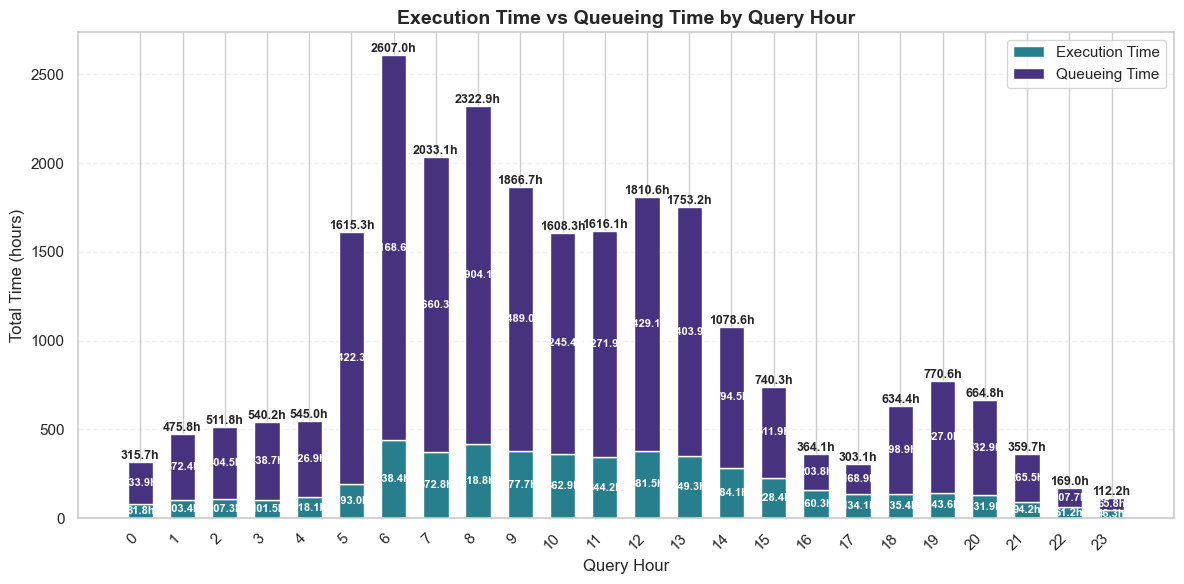


Summary by Query Hour:
 QUERY_HOUR  query_count  total_execution_hr  total_queueing_hr  total_time_hr
          0        23599           81.775000         233.942333     315.717333
          1        26440          103.414500         372.434000     475.848500
          2        30951          107.315667         404.507167     511.822833
          3        28912          101.541167         438.670667     540.211833
          4        39743          118.092333         426.929833     545.022167
          5        61664          193.038000        1422.254667    1615.292667
          6       196929          438.402333        2168.576500    2606.978833
          7       179089          372.786167        1660.285167    2033.071333
          8       190412          418.819667        1904.124000    2322.943667
          9       179896          377.716333        1488.958000    1866.674333
         10       170886          362.902667        1245.408167    1608.310833
         11       164498    

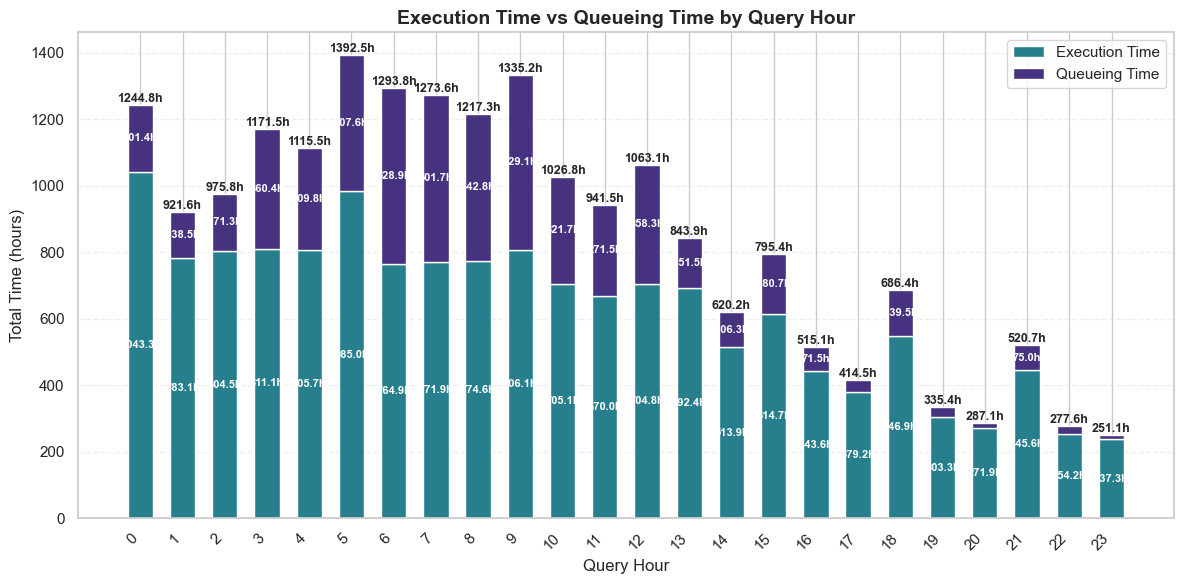


Summary by Query Hour:
 QUERY_HOUR  query_count  total_execution_hr  total_queueing_hr  total_time_hr
          0        69323         1043.332833         201.420667    1244.753500
          1        67802          783.077500         138.547167     921.624667
          2        50287          804.452833         171.332167     975.785000
          3        39384          811.104333         360.353333    1171.457667
          4        40538          805.706833         309.775167    1115.482000
          5        35399          984.992167         407.555833    1392.548000
          6        37431          764.889667         528.947500    1293.837167
          7        53854          771.939500         501.658500    1273.598000
          8        60008          774.551167         442.755500    1217.306667
          9        49436          806.099167         529.082833    1335.182000
         10        52637          705.127333         321.703167    1026.830500
         11        54082    

In [17]:
visualise_execution_and_queueing_time(
    query_df[query_df["WAREHOUSE_NAME"] == "BI TOOL"], "QUERY_HOUR"
)
visualise_execution_and_queueing_time(
    query_df[query_df["WAREHOUSE_NAME"] == "SCHEDULER"], "QUERY_HOUR"
)

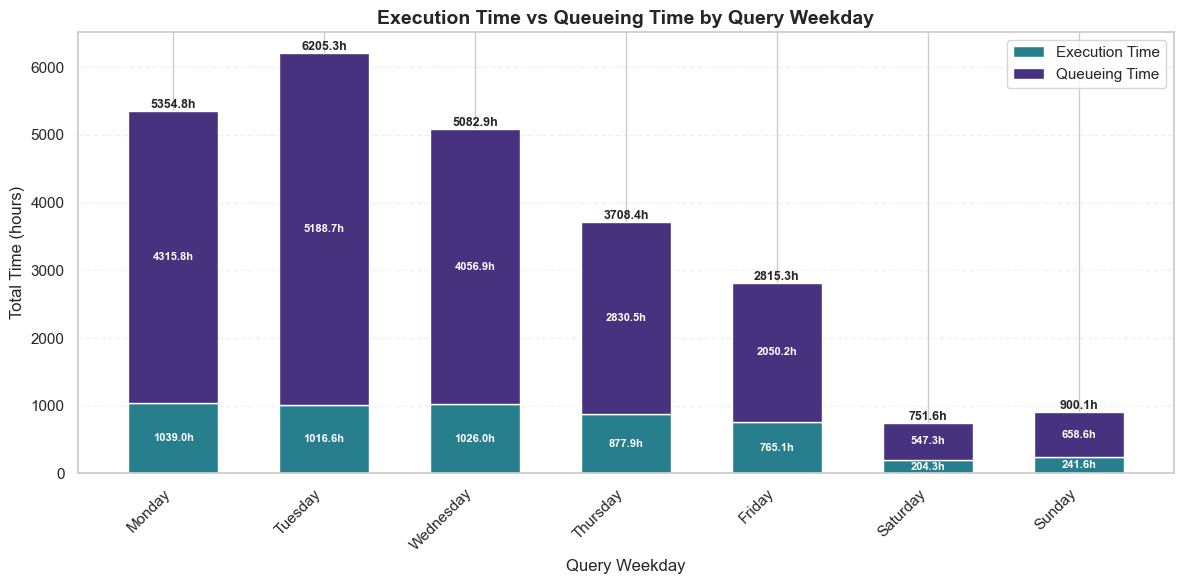


Summary by Query Weekday:
QUERY_WEEKDAY  query_count  total_execution_hr  total_queueing_hr  total_time_hr
       Monday       454087         1038.980500        4315.826833    5354.807333
      Tuesday       447541         1016.607667        5188.728000    6205.335667
    Wednesday       439102         1025.973667        4056.943000    5082.916667
     Thursday       389287          877.911167        2830.511000    3708.422167
       Friday       336524          765.055667        2050.231167    2815.286833
     Saturday        57095          204.323000         547.322833     751.645833
       Sunday        74252          241.551000         658.558333     900.109333


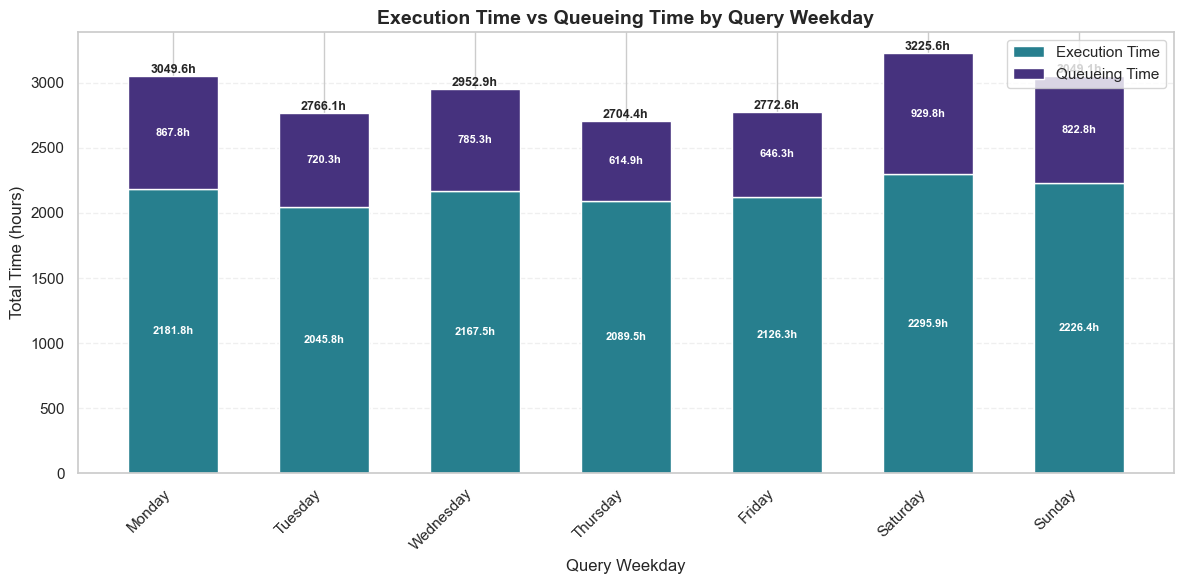


Summary by Query Weekday:
QUERY_WEEKDAY  query_count  total_execution_hr  total_queueing_hr  total_time_hr
       Monday       150350         2181.829833         867.769167    3049.599000
      Tuesday       151150         2045.801667         720.272500    2766.074167
    Wednesday       164294         2167.513000         785.344333    2952.857333
     Thursday       171021         2089.451000         614.932500    2704.383500
       Friday       162555         2126.309833         646.290167    2772.600000
     Saturday       136498         2295.864000         929.753167    3225.617167
       Sunday       128986         2226.375833         822.761667    3049.137500


In [18]:
visualise_execution_and_queueing_time(query_df[query_df['WAREHOUSE_NAME'] == 'BI TOOL'], 'QUERY_WEEKDAY')
visualise_execution_and_queueing_time(query_df[query_df['WAREHOUSE_NAME'] == 'SCHEDULER'], 'QUERY_WEEKDAY')


In [19]:
# Ensure warehouse_summary is defined (calculate if not already done)
if 'warehouse_summary' not in globals():
    warehouse_summary = summarize_query_perf(
        query_df,
        group_cols='WAREHOUSE_NAME',
        extra_aggs={
            'queue_time_total_min': ('QUEUEING_TIME_MIN', 'sum'),
            'exec_time_total_min': ('EXECUTION_TIME_MIN', 'sum'),
        },
        sort_by='p90_total_min',
        ascending=False,
        reset_index=True,
    )
    
print("Warehouse summary calculated:")
display(warehouse_summary.head())


Warehouse summary calculated:


,WAREHOUSE_NAME,queries,median_total_min,p90_total_min,mean_total_min,queue_time_total_min,exec_time_total_min
2,SCHEDULER,1064854,0.04,3.03,1.17,323227.41,907988.71
1,BI TOOL,2197888,0.20,1.96,0.69,1178887.27,310224.16
0,ANALYSTS,948482,0.00,0.10,0.13,28164.46,95622.68


## P90 Threshold Analysis

This section uses the P90 (90th percentile) threshold as a benchmark to identify and analyze slow queries. Queries at or above the P90 threshold represent the slowest 10% of all queries and are the primary focus for performance optimization.

**Why P90?**
- Captures the worst-performing queries that have the most impact on user experience
- Provides a category-specific threshold (each category has its own P90)
- Helps identify patterns in slow query behavior

### Overview: Fast Queries (< P90) vs Slow Queries (>= P90)

This analysis splits queries into two categories:
- **Fast Queries (< P90)**: Queries below the 90th percentile threshold
- **Slow Queries (>= P90)**: Queries at or above the 90th percentile threshold

This split helps understand:
- The distribution of query performance
- Time breakdown differences between fast and slow queries
- Overall impact of slow queries on system resources

P90 THRESHOLD CALCULATION
P90 Threshold: 1.86 minutes

This means queries taking >= 1.86 minutes are in the slowest 10%
These are the queries we want to focus our analysis on.

DATA SPLIT SUMMARY
Total queries: 4,211,224
Slow queries (>= P90, >= 1.86 min): 423,416 (10.1%)
Fast queries (< P90, < 1.86 min): 3,787,808 (89.9%)

SLOW QUERIES (P90+) STATISTICS
Min time: 1.86 min
Max time: 328.23 min
Mean time: 4.53 min
Median time: 2.98 min
P95: 10.20 min
P99: 25.51 min


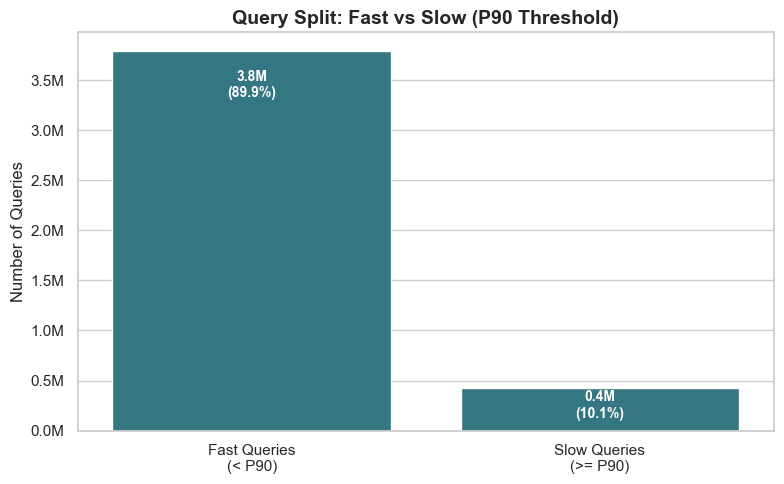


TIME BREAKDOWN FOR SLOW QUERIES (P90+)


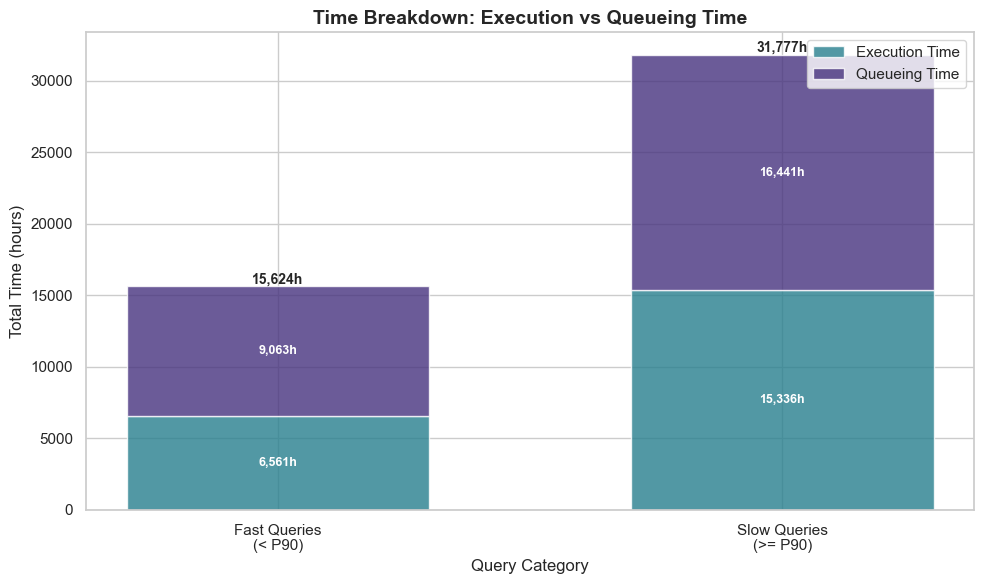


NOTE: All subsequent analysis will focus on slow queries (>= P90)


In [20]:
# Calculate P90 threshold - this is our cutoff for "slow queries"
P90_THRESHOLD = query_df['TOTAL_TIME_MIN'].quantile(0.90)
print("=" * 70)
print("P90 THRESHOLD CALCULATION")
print("=" * 70)
print(f"P90 Threshold: {P90_THRESHOLD:.2f} minutes")
print(f"\nThis means queries taking >= {P90_THRESHOLD:.2f} minutes are in the slowest 10%")
print(f"These are the queries we want to focus our analysis on.\n")

# Create filtered dataset for slow queries (P90+)
slow_queries_df = query_df[query_df['TOTAL_TIME_MIN'] >= P90_THRESHOLD].copy()
fast_queries_df = query_df[query_df['TOTAL_TIME_MIN'] < P90_THRESHOLD].copy()

print("=" * 70)
print("DATA SPLIT SUMMARY")
print("=" * 70)
print(f"Total queries: {len(query_df):,}")
print(f"Slow queries (>= P90, >= {P90_THRESHOLD:.2f} min): {len(slow_queries_df):,} ({len(slow_queries_df)/len(query_df)*100:.1f}%)")
print(f"Fast queries (< P90, < {P90_THRESHOLD:.2f} min): {len(fast_queries_df):,} ({len(fast_queries_df)/len(query_df)*100:.1f}%)")

# Summary statistics for slow queries
print("\n" + "=" * 70)
print("SLOW QUERIES (P90+) STATISTICS")
print("=" * 70)
print(f"Min time: {slow_queries_df['TOTAL_TIME_MIN'].min():.2f} min")
print(f"Max time: {slow_queries_df['TOTAL_TIME_MIN'].max():.2f} min")
print(f"Mean time: {slow_queries_df['TOTAL_TIME_MIN'].mean():.2f} min")
print(f"Median time: {slow_queries_df['TOTAL_TIME_MIN'].median():.2f} min")
print(f"P95: {slow_queries_df['TOTAL_TIME_MIN'].quantile(0.95):.2f} min")
print(f"P99: {slow_queries_df['TOTAL_TIME_MIN'].quantile(0.99):.2f} min")

# Visualize the query split
split_df = pd.DataFrame({
    'Category': ['Fast Queries\n(< P90)', 'Slow Queries\n(>= P90)'],
    'Count': [len(fast_queries_df), len(slow_queries_df)]
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=split_df, x='Category', y='Count', color=ALT_ACCENT)
ax.set_ylabel('Number of Queries', fontsize=12)
ax.set_xlabel('')
ax.set_title('Query Split: Fast vs Slow (P90 Threshold)', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1_000_000:.1f}M"))

# Add value labels on bars (inside the bars to avoid going outside)
for i, (bar, count) in enumerate(zip(ax.patches, split_df['Count'])):
    height = bar.get_height()
    pct = count / len(query_df) * 100
    # Position label inside the bar, near the top but with some margin
    label_y = height * 0.95  # 95% of the bar height
    ax.text(bar.get_x() + bar.get_width()/2., label_y,
             f'{count/1_000_000:.1f}M\n({pct:.1f}%)',
             ha='center', va='top', fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Analyze time breakdown for slow queries
print("\n" + "=" * 70)
print("TIME BREAKDOWN FOR SLOW QUERIES (P90+)")
print("=" * 70)

# Calculate total time components
slow_total_exec_min = slow_queries_df['EXECUTION_TIME_MIN'].sum()
slow_total_queue_min = slow_queries_df['QUEUEING_TIME_MIN'].sum()
slow_total_time_min = slow_total_exec_min + slow_total_queue_min

fast_total_exec_min = fast_queries_df['EXECUTION_TIME_MIN'].sum()
fast_total_queue_min = fast_queries_df['QUEUEING_TIME_MIN'].sum()
fast_total_time_min = fast_total_exec_min + fast_total_queue_min

# Create stacked bar plot for time breakdown
time_breakdown_df = pd.DataFrame({
    'Category': ['Fast Queries\n(< P90)', 'Slow Queries\n(>= P90)'],
    'Execution Time (hours)': [fast_total_exec_min/60, slow_total_exec_min/60],
    'Queueing Time (hours)': [fast_total_queue_min/60, slow_total_queue_min/60]
})

fig, ax = plt.subplots(figsize=(10, 6))

# Create stacked bars
x_pos = np.arange(len(time_breakdown_df))
width = 0.6

bars1 = ax.bar(x_pos, time_breakdown_df['Execution Time (hours)'], width, 
               label='Execution Time', color=ALT_ACCENT, alpha=0.8)
bars2 = ax.bar(x_pos, time_breakdown_df['Queueing Time (hours)'], width,
               bottom=time_breakdown_df['Execution Time (hours)'],
               label='Queueing Time', color=ALT_ACCENT_2, alpha=0.8)

ax.set_xlabel('Query Category', fontsize=12)
ax.set_ylabel('Total Time (hours)', fontsize=12)
ax.set_title('Time Breakdown: Execution vs Queueing Time', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(time_breakdown_df['Category'])
ax.legend(loc='upper right', fontsize=11)

# Add value labels on bars
for i, (exec_hr, queue_hr) in enumerate(zip(
    time_breakdown_df['Execution Time (hours)'],
    time_breakdown_df['Queueing Time (hours)']
)):
    total_hr = exec_hr + queue_hr
    # Label for total on top
    ax.text(i, total_hr, f'{total_hr:,.0f}h',
            ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Label for execution time (if large enough)
    if exec_hr > total_hr * 0.1:
        ax.text(i, exec_hr / 2, f'{exec_hr:,.0f}h',
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # Label for queueing time (if large enough)
    if queue_hr > total_hr * 0.1:
        ax.text(i, exec_hr + queue_hr / 2, f'{queue_hr:,.0f}h',
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("NOTE: All subsequent analysis will focus on slow queries (>= P90)")
print("=" * 70)


### P90+ Analysis: Average Time and Query Count

This visualization shows two metrics for slow queries (P90+):
1. **Average Time**: Mean execution time per query for slow queries
2. **Average Queries**: Number of unique queries in the slow category

When analyzing by QUERY_TYPE, this function also breaks down results by WAREHOUSE_SIZE to show how query type and warehouse size interact.

TIME BREAKDOWN BY HUMAN_USER

P90 Thresholds by HUMAN_USER:
HUMAN_USER  p90_total_min
 Automated           1.86


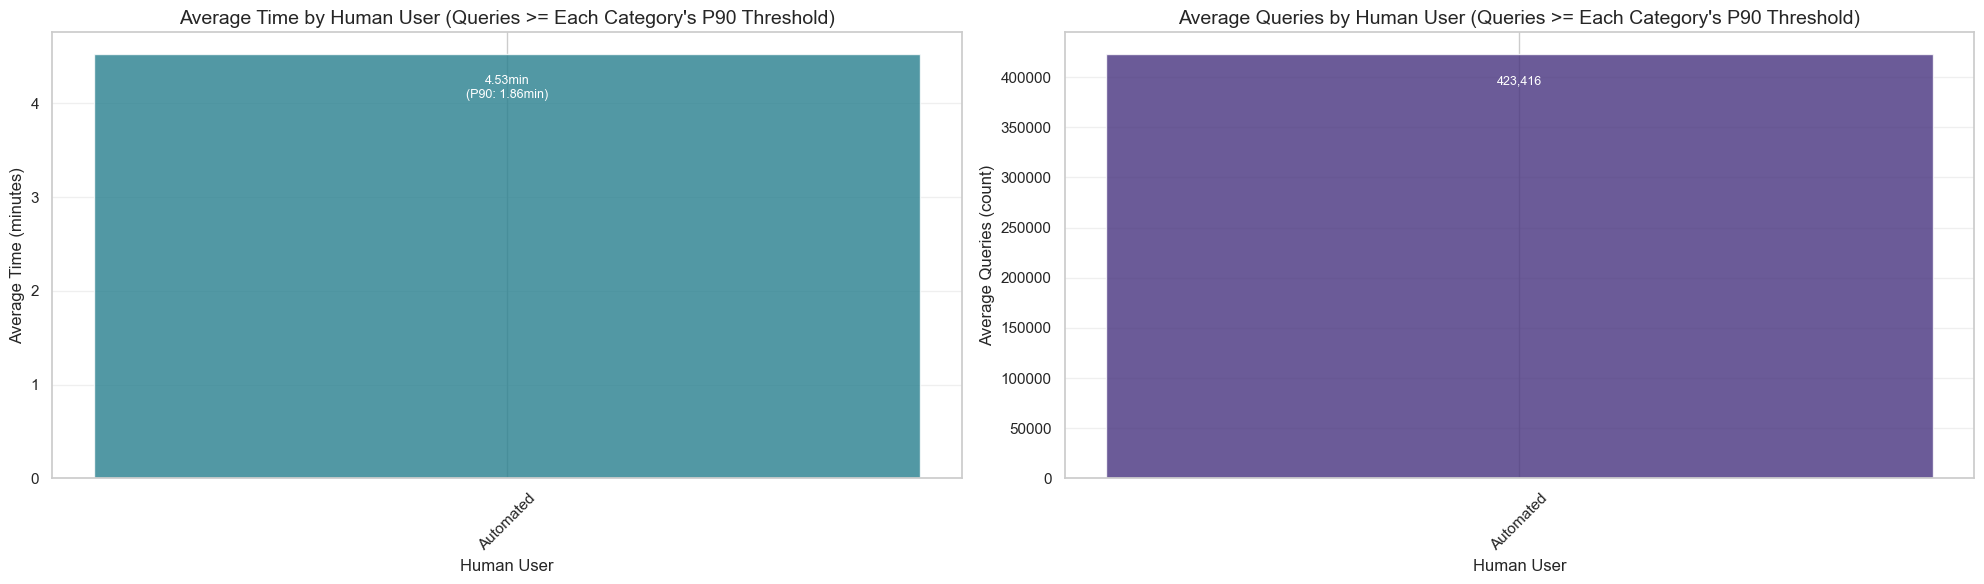

,Category,Average Time (min),Average Queries,P90 Threshold (min)
0,Automated,4.530458,423416,1.86


In [21]:
# Note: analyze_time_breakdown_by_category_with_size is now imported from visualization.py
# Use this function - it will automatically show WAREHOUSE_SIZE as columns when using QUERY_TYPE
analyze_time_breakdown_by_category_with_size(query_df, 'HUMAN_USER')


### Line Charts: Temporal Patterns for P90+ Queries

This section creates line charts showing how slow query performance varies over time:
- **By Query Hour**: Shows patterns throughout the day (0-23 hours)
- **By Weekday**: Shows patterns across the week (Monday-Sunday)

Each warehouse is shown as a separate line, allowing comparison of performance patterns across different warehouses.

QUERY HOUR AND WEEKDAY ANALYSIS BY WAREHOUSE (P90+ QUERIES)

Chart 1: Average Time by Query Hour (P90+ Queries)


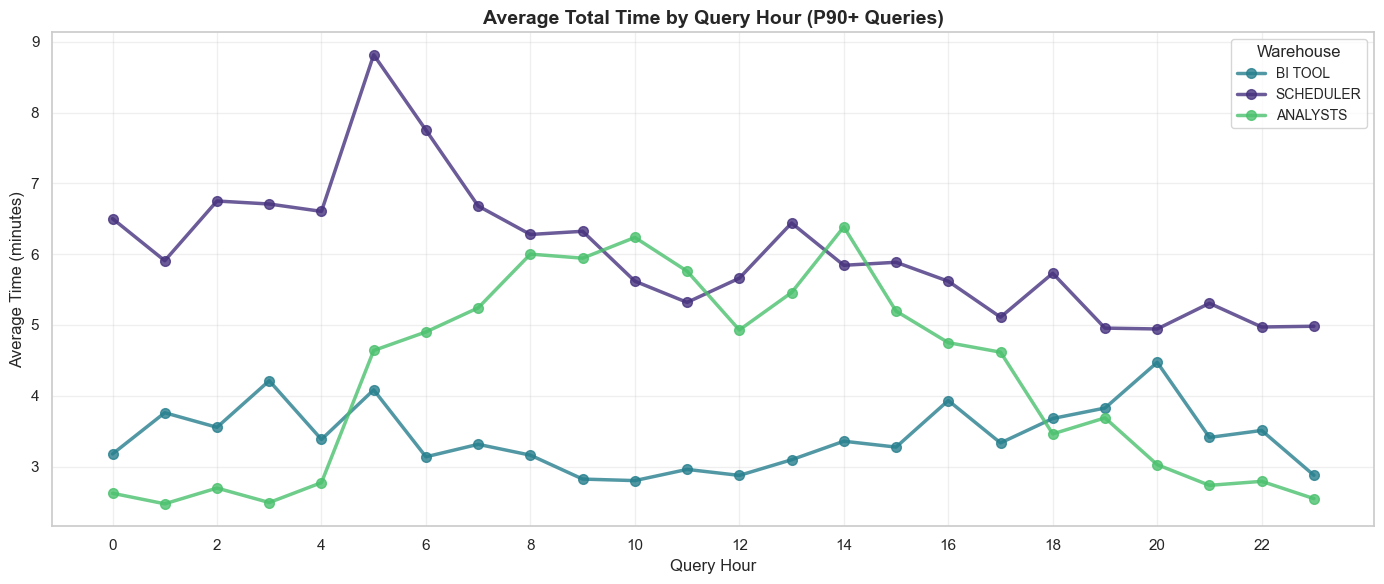


Chart 2: Average Time by Weekday (P90+ Queries)


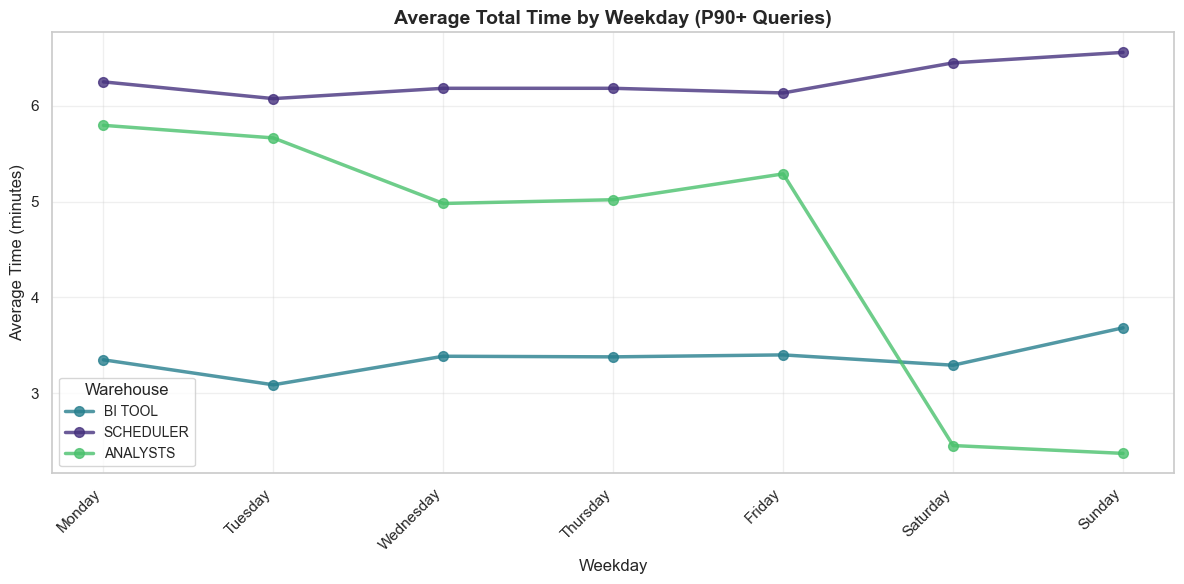

In [22]:
# Line charts: Query Hour and Weekday by Warehouse Name (P90+ queries)
print("=" * 70)
print("QUERY HOUR AND WEEKDAY ANALYSIS BY WAREHOUSE (P90+ QUERIES)")
print("=" * 70)

# Calculate P90 threshold if not already defined
if 'P90_THRESHOLD' not in globals():
    P90_THRESHOLD = query_df['TOTAL_TIME_MIN'].quantile(0.90)
    print(f"P90 Threshold: {P90_THRESHOLD:.2f} minutes\n")

# Filter for P90+ queries
slow_queries_df = query_df[query_df['TOTAL_TIME_MIN'] >= P90_THRESHOLD].copy()

# Get unique warehouses
warehouses = slow_queries_df['WAREHOUSE_NAME'].dropna().unique()
warehouse_colors = {warehouse: color for warehouse, color in 
                    zip(warehouses, [ALT_ACCENT, ALT_ACCENT_2, BASE_ACCENT] + BASE_PALETTE[:len(warehouses)-3])}

# ============================================================================
# CHART 1: X-axis = Query Hour (0-23), Lines = Warehouse Name
# ============================================================================
print("\nChart 1: Average Time by Query Hour (P90+ Queries)")

# Group by QUERY_HOUR and WAREHOUSE_NAME
hour_warehouse = slow_queries_df.groupby(
    ['QUERY_HOUR', 'WAREHOUSE_NAME'], 
    observed=True
).agg(
    avg_total_time_min=('TOTAL_TIME_MIN', 'mean'),
    query_count=('QUERY_ID', 'count')
).reset_index()

# Create line chart
fig1, ax1 = plt.subplots(figsize=(14, 6))

# Plot a line for each warehouse
for warehouse in warehouses:
    warehouse_data = hour_warehouse[hour_warehouse['WAREHOUSE_NAME'] == warehouse]
    if len(warehouse_data) > 0:
        # Sort by hour
        warehouse_data = warehouse_data.sort_values('QUERY_HOUR')
        ax1.plot(warehouse_data['QUERY_HOUR'], 
                warehouse_data['avg_total_time_min'],
                marker='o', 
                linewidth=2.5, 
                markersize=7,
                label=warehouse,
                color=warehouse_colors[warehouse],
                alpha=0.8)

ax1.set_xlabel('Query Hour', fontsize=12)
ax1.set_ylabel('Average Time (minutes)', fontsize=12)
ax1.set_title('Average Total Time by Query Hour (P90+ Queries)', fontsize=14, fontweight='bold')
ax1.set_xticks(range(0, 24, 2))
ax1.grid(True, alpha=0.3)
ax1.legend(title='Warehouse', fontsize=10, loc='best')
plt.tight_layout()
plt.show()

# ============================================================================
# CHART 2: X-axis = Weekday, Lines = Warehouse Name
# ============================================================================
print("\nChart 2: Average Time by Weekday (P90+ Queries)")

# Group by QUERY_WEEKDAY and WAREHOUSE_NAME
weekday_warehouse = slow_queries_df.groupby(
    ['QUERY_WEEKDAY', 'WAREHOUSE_NAME'], 
    observed=True
).agg(
    avg_total_time_min=('TOTAL_TIME_MIN', 'mean'),
    query_count=('QUERY_ID', 'count')
).reset_index()

# Order weekdays properly
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_warehouse['QUERY_WEEKDAY'] = pd.Categorical(
    weekday_warehouse['QUERY_WEEKDAY'], 
    categories=weekday_order, 
    ordered=True
)
weekday_warehouse = weekday_warehouse.sort_values(['QUERY_WEEKDAY'])

# Create line chart
fig2, ax2 = plt.subplots(figsize=(12, 6))

# Get all weekdays that exist in data
available_weekdays = weekday_warehouse['QUERY_WEEKDAY'].dropna().unique()
available_weekdays = sorted(available_weekdays, key=lambda x: weekday_order.index(x) if x in weekday_order else 99)

# Plot a line for each warehouse
for warehouse in warehouses:
    warehouse_data = weekday_warehouse[weekday_warehouse['WAREHOUSE_NAME'] == warehouse]
    if len(warehouse_data) > 0:
        # Sort by weekday order
        warehouse_data = warehouse_data.sort_values('QUERY_WEEKDAY')
        # Create mapping from weekday to index for plotting
        weekday_to_idx = {day: idx for idx, day in enumerate(available_weekdays)}
        x_values = [weekday_to_idx[day] for day in warehouse_data['QUERY_WEEKDAY']]
        ax2.plot(x_values, 
                warehouse_data['avg_total_time_min'],
                marker='o', 
                linewidth=2.5, 
                markersize=7,
                label=warehouse,
                color=warehouse_colors[warehouse],
                alpha=0.8)

ax2.set_xlabel('Weekday', fontsize=12)
ax2.set_ylabel('Average Time (minutes)', fontsize=12)
ax2.set_title('Average Total Time by Weekday (P90+ Queries)', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(available_weekdays)))
ax2.set_xticklabels(available_weekdays, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
ax2.legend(title='Warehouse', fontsize=10, loc='best')
plt.tight_layout()
plt.show()

